# Plot Backend

Plots the APE, RPE and trajectory against ground truth for the final backend output trajectory.

In [1]:
import yaml
import os
import copy
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
from numpy import linalg as la
import math

import logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
if not log.handlers:
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(logging.Formatter('%(levelname)s - %(message)s'))
    log.addHandler(ch)
    
from evo.tools import file_interface
from evo.tools import plot
from evo.tools import pandas_bridge

from evo.core import sync
from evo.core import trajectory
from evo.core import metrics
from evo.core import transformations
from evo.core import lie_algebra as lie

from evaluation.evaluation_lib import (
    get_ape_trans, 
    get_ape_rot, 
    get_rpe_trans, 
    get_rpe_rot,
    plot_metric, 
    plot_traj_colormap_ape, 
    plot_traj_colormap_rpe,
    convert_abs_traj_to_rel_traj
)

#%matplotlib inline
#%matplotlib widget
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import mpl_toolkits.mplot3d.art3d as art3d

## Data Locations

Make sure to set the following paths.

`vio_output_dir` is the path to the directory containing `output_*.csv` files obtained from logging a run of SparkVio.

`gt_data_file` is the absolute path to the `csv` file containing ground truth data for the absolute pose at each timestamp of the dataset.

In [528]:
# Define directory to VIO output csv files as well as ground truth absolute poses.
vio_output_dir = "/home/wxm/Documents/code/ORB_SLAM3/data/output_logs"
gt_data_file = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/state_groundtruth_estimate0/data.csv"

In [529]:
def rename_pim_df(df):
    """ Renames a DataFrame built from a PIM measurements csv file to be converted to a trajectory.
    
        This is an 'inplace' argument and returns nothing.
    
        Args:
            df: A pandas.DataFrame object.
    """
    df.index.names = ["timestamp"]
    df.rename(columns={"tx": "x",
                       "ty": "y",
                       "tz": "z"}, inplace=True)

# show coordinate axes
def colored_line_collection(xyz, colors, plot_mode=plot.PlotMode.xy,
                            linestyles="solid", step=2, alpha=1.):
    if len(xyz) / step != len(colors):
        raise PlotException(
            "color values don't have correct length: %d vs. %d" %
            (len(xyz) / step, len(colors)))
    x_idx, y_idx, z_idx = plot.plot_mode_to_idx(plot_mode)
    xs = [[x_1, x_2]
          for x_1, x_2 in zip(xyz[:-1:step, x_idx], xyz[1::step, x_idx])]
    ys = [[x_1, x_2]
          for x_1, x_2 in zip(xyz[:-1:step, y_idx], xyz[1::step, y_idx])]
    if plot_mode == plot.PlotMode.xyz:
        zs = [[x_1, x_2]
              for x_1, x_2 in zip(xyz[:-1:step, z_idx], xyz[1::step, z_idx])]
        segs = [list(zip(x, y, z)) for x, y, z in zip(xs, ys, zs)]
        line_collection = art3d.Line3DCollection(segs, colors=colors,
                                                 alpha=alpha,
                                                 linestyles=linestyles)
    else:
        segs = [list(zip(x, y)) for x, y in zip(xs, ys)]
        line_collection = LineCollection(segs, colors=colors, alpha=alpha,
                                         linestyle=linestyles)
    return line_collection

def draw_coordinate_axes(ax, traj, plot_mode, downsample_ratio=20, marker_scale=1, x_color="r",
                         y_color="g", z_color="b"):
    """
    Draws a coordinate frame axis for each pose of a trajectory.
    :param ax: plot axis
    :param traj: trajectory.PosePath3D or trajectory.PoseTrajectory3D object
    :param plot_mode: PlotMode value
    :param marker_scale: affects the size of the marker (1. * marker_scale)
    :param x_color: color of the x-axis
    :param y_color: color of the y-axis
    :param z_color: color of the z-axis
    """
    if marker_scale <= 0:
        return

    unit_x = np.array([1 * marker_scale, 0, 0, 1])
    unit_y = np.array([0, 1 * marker_scale, 0, 1])
    unit_z = np.array([0, 0, 1 * marker_scale, 1])

    # Transform start/end vertices of each axis to global frame.
    x_vertices = np.array([[p[:3, 3], p.dot(unit_x)[:3]]
                           for p in traj.poses_se3[::downsample_ratio]])
    y_vertices = np.array([[p[:3, 3], p.dot(unit_y)[:3]]
                           for p in traj.poses_se3[::downsample_ratio]])
    z_vertices = np.array([[p[:3, 3], p.dot(unit_z)[:3]]
                           for p in traj.poses_se3[::downsample_ratio]])

    n = len(traj.poses_se3[::downsample_ratio])
    # Concatenate all line segment vertices in order x, y, z.
    vertices = np.concatenate((x_vertices, y_vertices, z_vertices)).reshape(
        (n * 2 * 3, 3))
    # Concatenate all colors per line segment in order x, y, z.
    colors = np.array(n * [x_color] + n * [y_color] + n * [z_color])

    markers = colored_line_collection(vertices, colors, plot_mode, step=2)
    ax.add_collection(markers)
    
def draw_start_and_end(ax, traj, plot_mode):
    """Draw start and end points of the trajectory
    """
    start_pose = traj.poses_se3[0]
    end_pose = traj.poses_se3[-1]
    if plot_mode == plot.PlotMode.xy:
        ax.plot(start_pose[0,3], start_pose[1,3], 'bo')
        ax.plot(end_pose[0,3], end_pose[1,3], 'rx')

## Backend Trajectory

Associate, align and process the trajectory as determined by the backend. Note that this does not include loop closure factors or other optimizations. This is pure VIO.

In [530]:
# Load ground truth and estimated data as csv DataFrames.
gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)
gt_df = gt_df[~gt_df.index.duplicated()]

# Convert the gt relative-pose DataFrame to a trajectory object.
traj_ref_complete = pandas_bridge.df_to_trajectory(gt_df)

In [531]:
#tracking output pose
output_poses_filename = os.path.join(os.path.expandvars(vio_output_dir), "CameraTrajectory.csv")
output_poses_df = pd.read_csv(output_poses_filename, sep=',', index_col=0)

In [532]:


# Use the backend poses as trajectory.
traj_est_unaligned = pandas_bridge.df_to_trajectory(output_poses_df)
discard_n_start_poses = 0
discard_n_end_poses = 0

# Associate the data.
traj_est = copy.deepcopy(traj_est_unaligned)
traj_ref, traj_est = sync.associate_trajectories(traj_ref_complete, traj_est)
traj_est = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=False,
                                       discard_n_start_poses = int(discard_n_start_poses),
                                       discard_n_end_poses = int(discard_n_end_poses))

print("traj_ref: ", traj_ref)
print("traj_est: ", traj_est)

traj_ref:  2205 poses, 11.269m path length, 78.089s duration
traj_est:  2205 poses, 12.292m path length, 78.084s duration


<IPython.core.display.Javascript object>


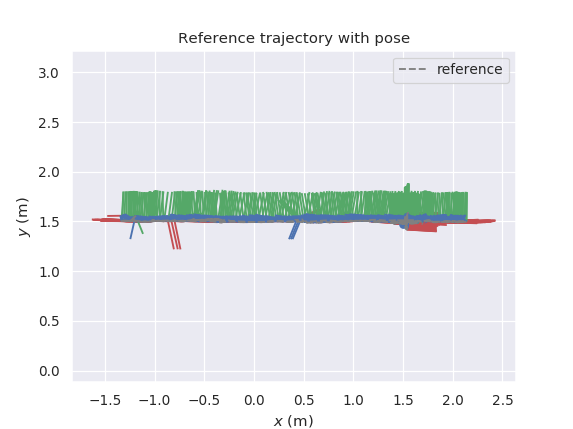

<IPython.core.display.Javascript object>


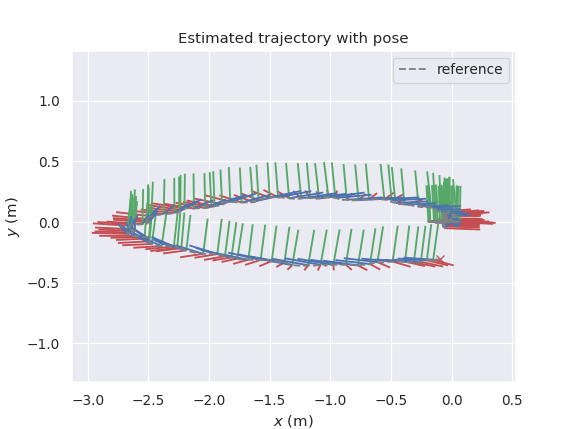

In [533]:
# plot ground truth trajectory with pose
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
draw_coordinate_axes(ax, traj_ref_complete, marker_scale=0.3, downsample_ratio=20, plot_mode=plot_mode)
draw_start_and_end(ax, traj_ref_complete, plot_mode)
plot.traj(ax, plot_mode, traj_ref_complete, '--', "gray", "reference")
plt.title('Reference trajectory with pose')
plt.show()

# plot unaligned trajectory with pose
plot_mode = plot.PlotMode.xy
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)
draw_coordinate_axes(ax, traj_est_unaligned, marker_scale=0.3, plot_mode=plot_mode)
draw_start_and_end(ax, traj_est_unaligned, plot_mode)
plot.traj(ax, plot_mode, traj_est_unaligned, '--', "gray", "reference")
plt.title('Estimated trajectory with pose')
plt.show()

<IPython.core.display.Javascript object>


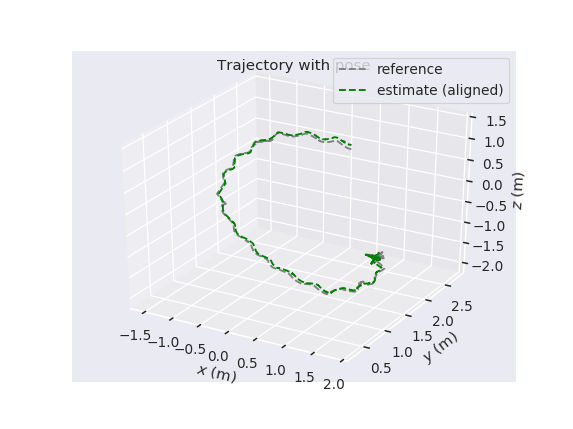

In [534]:
plot_mode = plot.PlotMode.xyz
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode)

gt_df_downsampled = gt_df.iloc[:1200:100]


# reference trajectory
traj_ref_downsampled = pandas_bridge.df_to_trajectory(gt_df_downsampled)
#draw_coordinate_axes(ax, traj_ref, plot_mode=plot_mode,marker_scale=0.3)
#draw_coordinate_axes(ax, traj_est, plot_mode=plot_mode,marker_scale=0.3)
plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
plot.traj(ax, plot_mode, traj_est, '--', "green", "estimate (aligned)")

plt.title('Trajectory with pose')
plt.show()

## Absolute-Pose-Error Plotting

Plot absolute-pose-error along the entire trajectory. APE gives a good sense of overall VIO performance across the entire trajectory.

### Absolute Translation Errors

The following two plots show 1) VIO's absolute translation errors (ATE) in meters with respect to time, and 2) estimated trajectory color coded by magnitudes of the ATE.

<IPython.core.display.Javascript object>


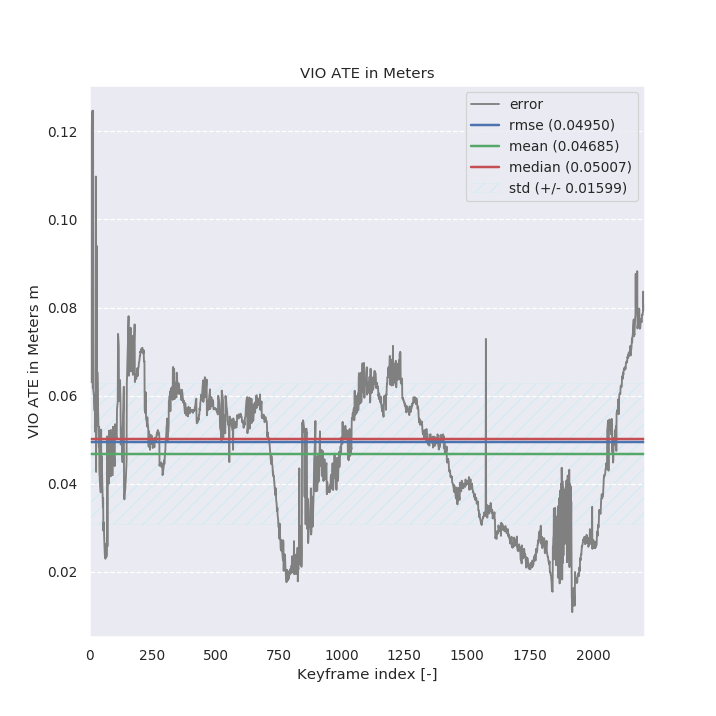

In [535]:
# Plot APE of trajectory rotation and translation parts.
num_of_poses = traj_est.num_poses
traj_est.reduce_to_ids(range(int(discard_n_start_poses), int(num_of_poses - discard_n_end_poses), 1))
traj_ref.reduce_to_ids(range(int(discard_n_start_poses), int(num_of_poses - discard_n_end_poses), 1))

seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps]

ape_tran = get_ape_trans((traj_ref, traj_est))
fig1 = plot_metric(ape_tran, "VIO ATE in Meters")
plt.show()

<IPython.core.display.Javascript object>


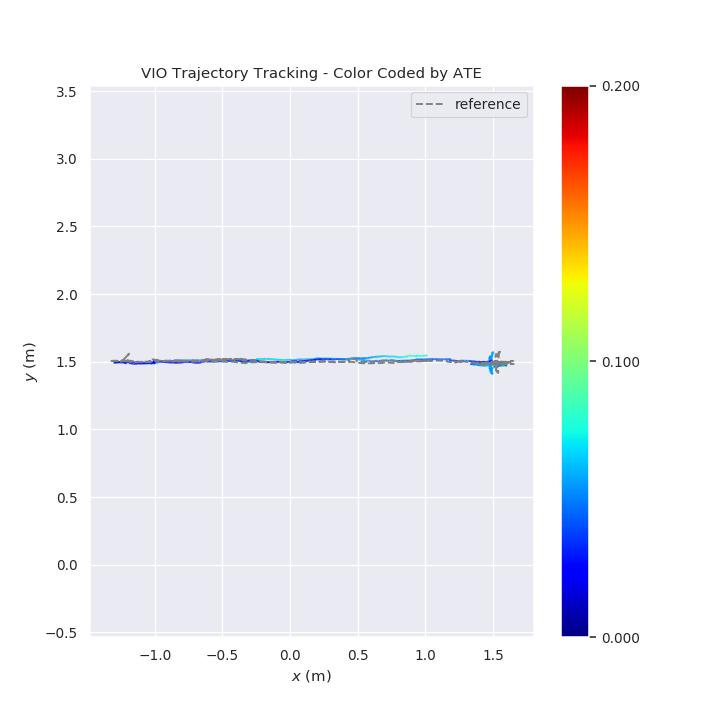

In [536]:
# Plot the ground truth and estimated trajectories against each other with APE overlaid.
fig = plot_traj_colormap_ape(ape_tran, traj_ref, traj_est,
                             plot_title="VIO Trajectory Tracking - Color Coded by ATE")
plt.show()

### Absolute Rotation Errors

The following two plots show 1) VIO's absolute rotation errors (ARE) in meters with respect to time, and 2) estimated trajectory color coded by magnitudes of the ARE. Note that the estimated trajectory used here, unlike ATE, is the unaligned, original estimated trajectory.

<IPython.core.display.Javascript object>


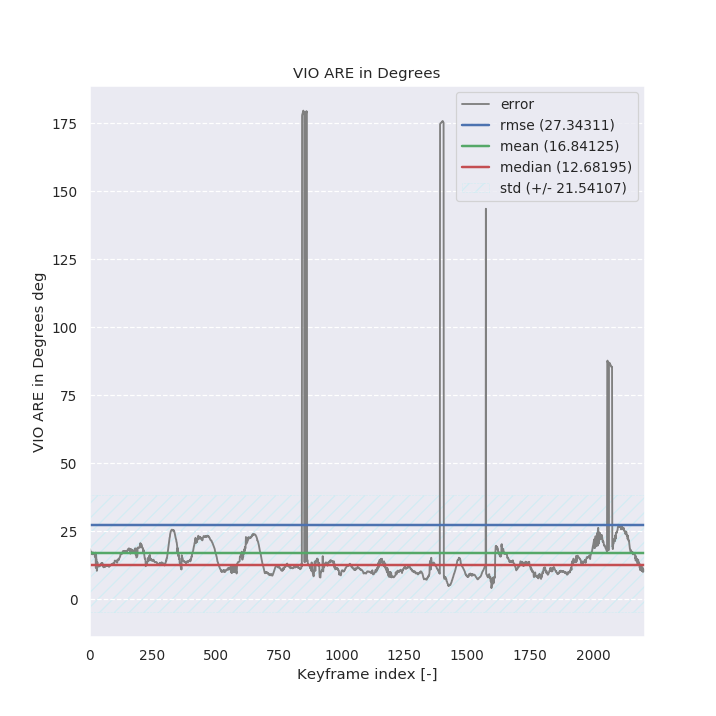

In [537]:
# Plot ARE
traj_est_unaligned.reduce_to_ids(range(int(discard_n_start_poses), int(num_of_poses - discard_n_end_poses), 1))

ape_rot = get_ape_rot((traj_ref, traj_est_unaligned))
fig2 = plot_metric(ape_rot, "VIO ARE in Degrees")
plt.show()

<IPython.core.display.Javascript object>


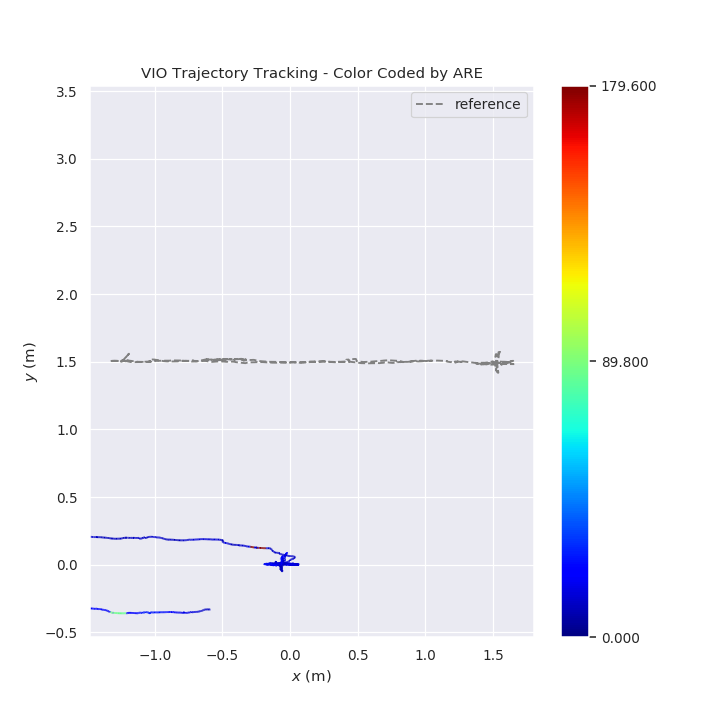

In [538]:
# Plot the ground truth and estimated trajectories against each other with APE overlaid.
fig2 = plot_traj_colormap_ape(ape_rot, traj_ref, traj_est_unaligned,
                             plot_title="VIO Trajectory Tracking - Color Coded by ARE")
plt.show()

## Relative-Pose-Error Plotting

Plot relative-pose-error along the entire trajectory. RPE gives a good sense of overall VIO performance from one frame to the next.

In [539]:
# Get RPE for entire relative trajectory.
rpe_rot = get_rpe_rot((traj_ref, traj_est))
rpe_tran = get_rpe_trans((traj_ref, traj_est))

### Relative Translation Errors

<IPython.core.display.Javascript object>


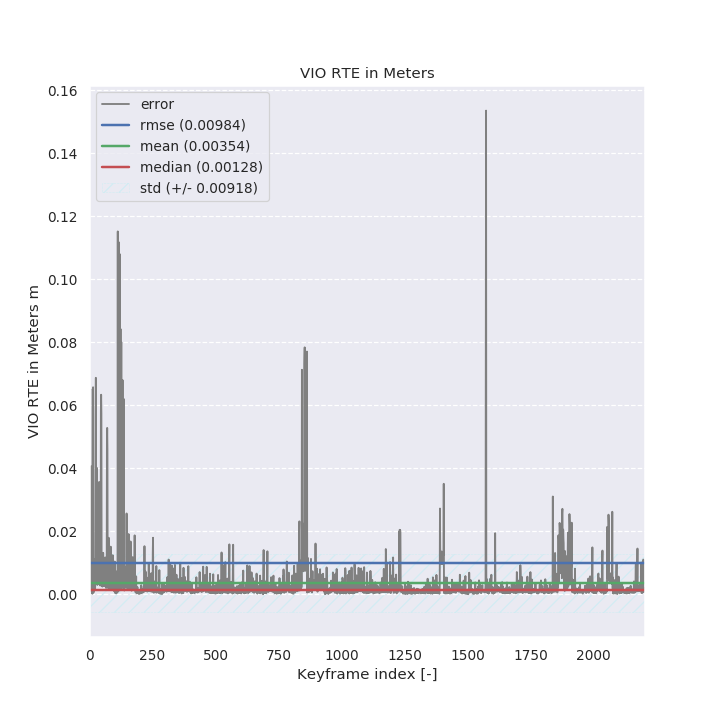

<IPython.core.display.Javascript object>


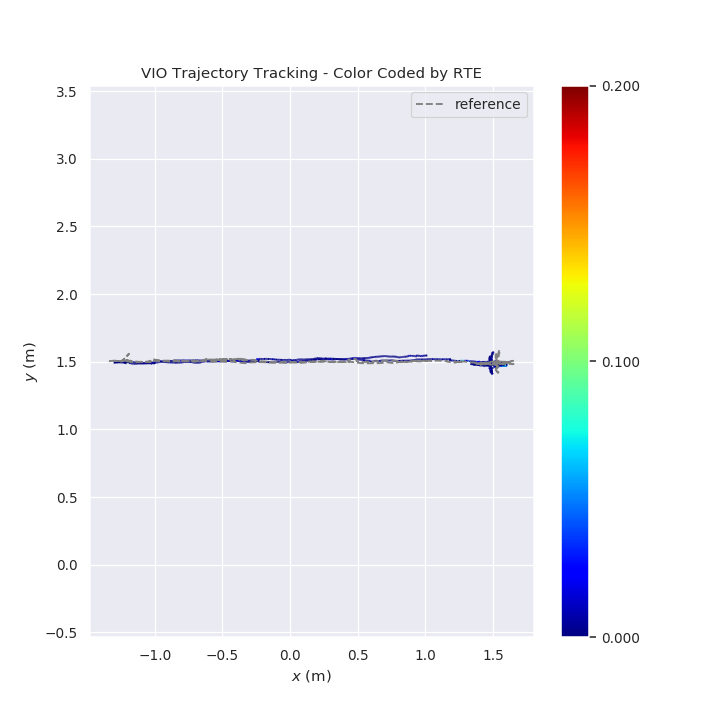

In [540]:
# Plot RPE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

fig1 = plot_metric(rpe_tran, "VIO RTE in Meters")
fig2 = plot_traj_colormap_rpe(rpe_tran, traj_ref, traj_est,
                             plot_title="VIO Trajectory Tracking - Color Coded by RTE")
plt.show()

### Relative Rotation Errors

<IPython.core.display.Javascript object>


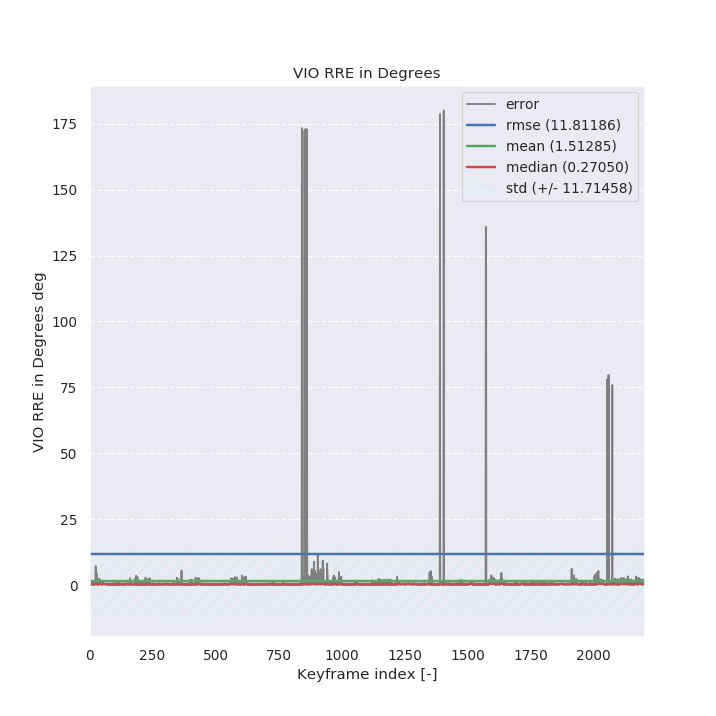

<IPython.core.display.Javascript object>


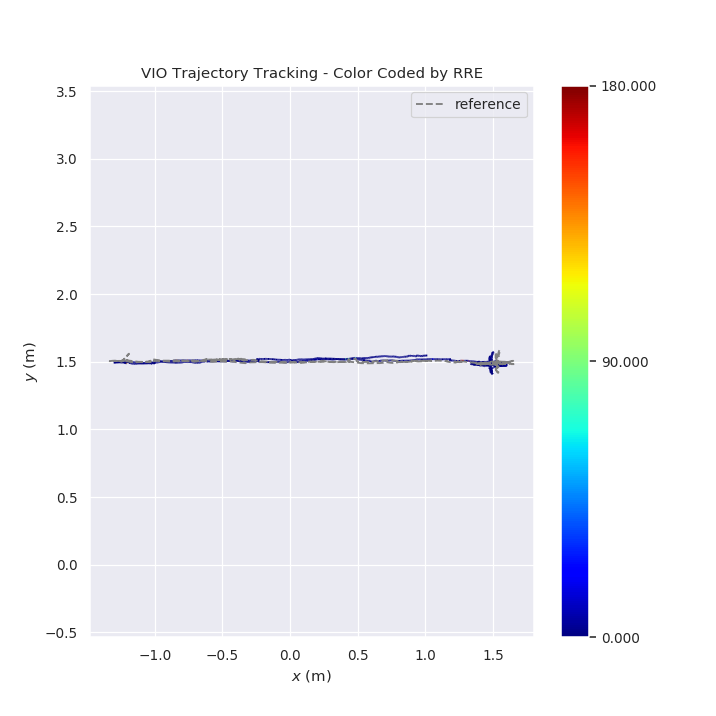

In [541]:
fig1 = plot_metric(rpe_rot, "VIO RRE in Degrees")
fig2 = plot_traj_colormap_rpe(rpe_rot, traj_ref, traj_est,
                             plot_title="VIO Trajectory Tracking - Color Coded by RRE")
plt.show()

<IPython.core.display.Javascript object>


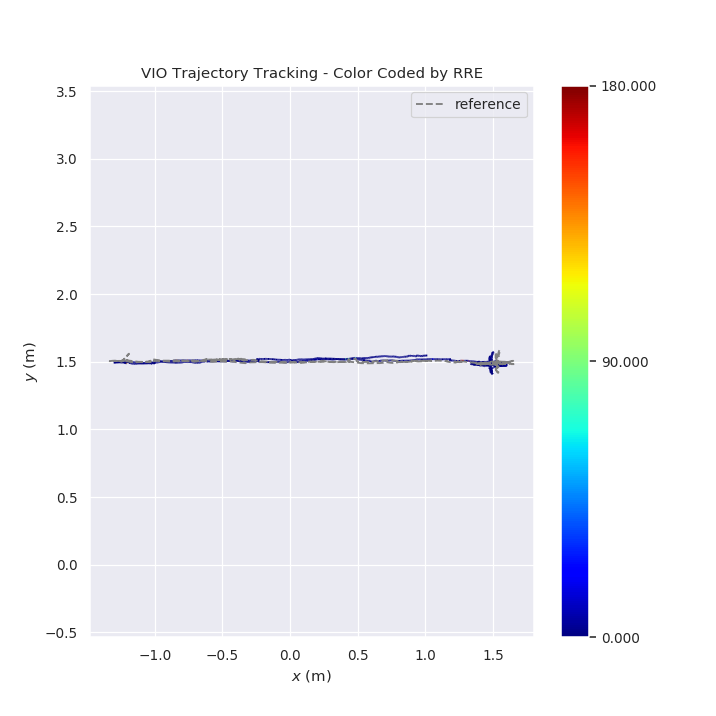

In [542]:
fig = plot_traj_colormap_rpe(rpe_rot, traj_ref, traj_est,
                             plot_title="VIO Trajectory Tracking - Color Coded by RRE")
plt.show()

## Trajectory Plotting

Plot the aligned and associated estimated trajectory against ground truth.

<IPython.core.display.Javascript object>


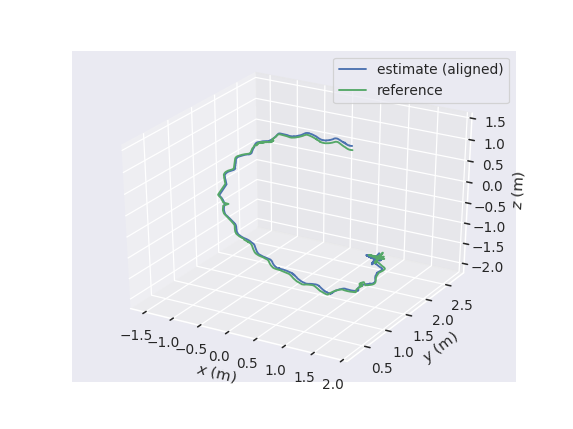

In [543]:
# Plot the trajectories for quick error visualization.

fig = plt.figure()
traj_by_label = {
    #"estimate (unaligned)": traj_est_unaligned,
    "estimate (aligned)": traj_est,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz, title="PIM Trajectory Tracking in 3D")
plt.show()

## IMU initializeing data

### dR

In [544]:
#timestamp,dR_x,dR_y,dR_z,dV_x,dV_y,dV_z,dP_x,dP_y,dP_z,scale,dt,g_x,g_y,g_z

<IPython.core.display.Javascript object>


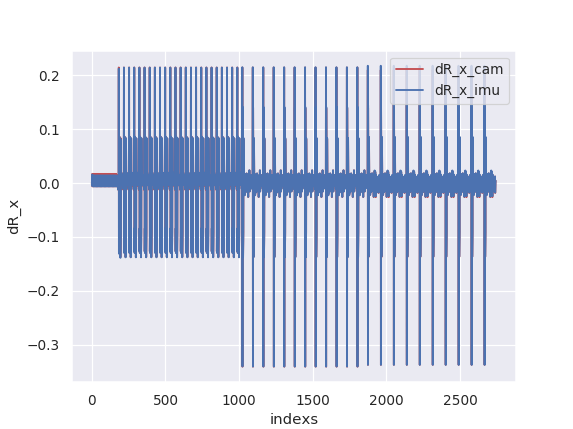

<IPython.core.display.Javascript object>


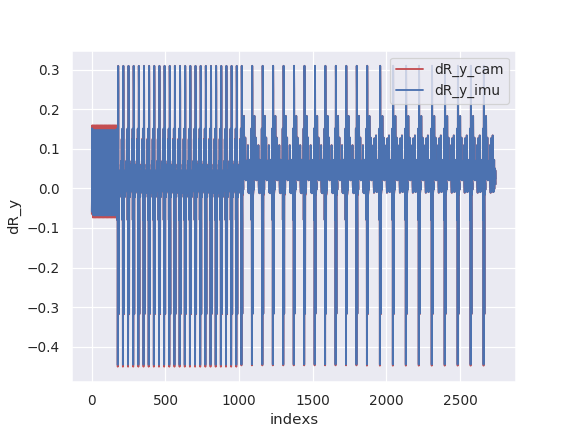

<IPython.core.display.Javascript object>


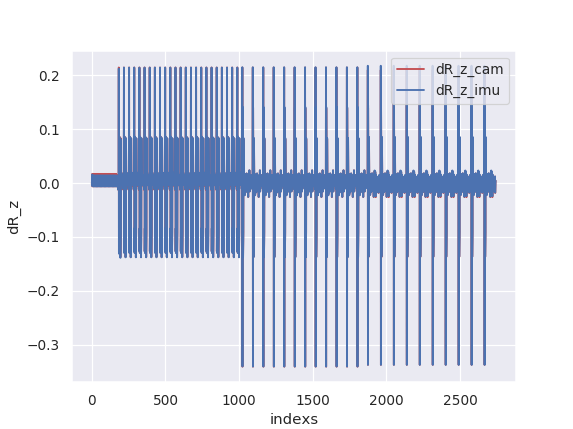

In [547]:
imu_init_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/output_logs/init_imu_data.csv"
imu_init_df = pd.read_csv(imu_init_filename, sep=',', index_col=0)

imu_init_df_1=imu_init_df[imu_init_df.index == 'cam']
imu_init_df_2=imu_init_df[imu_init_df.index == 'imu']


plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dR_x'], 'r', label='dR_x_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dR_x'], 'b', label='dR_x_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dR_x')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dR_y'], 'r', label='dR_y_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dR_y'], 'b', label='dR_y_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dR_y')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dR_x'], 'r', label='dR_z_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dR_x'], 'b', label='dR_z_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dR_z')
plt.show()


### dV

<IPython.core.display.Javascript object>


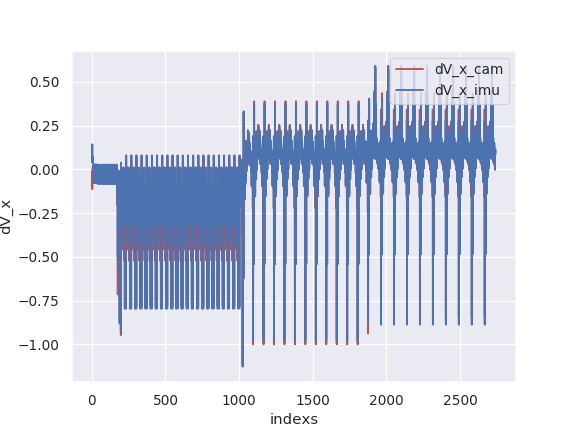

<IPython.core.display.Javascript object>


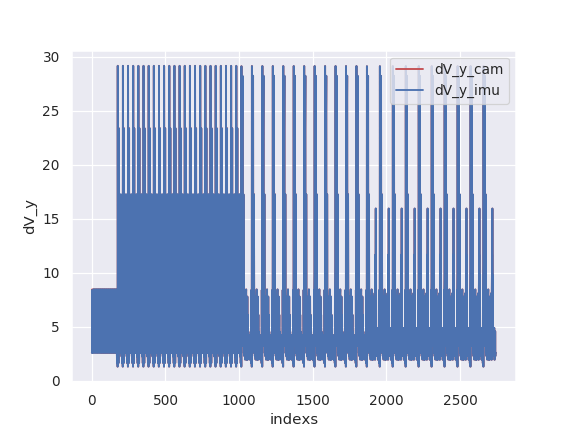

<IPython.core.display.Javascript object>


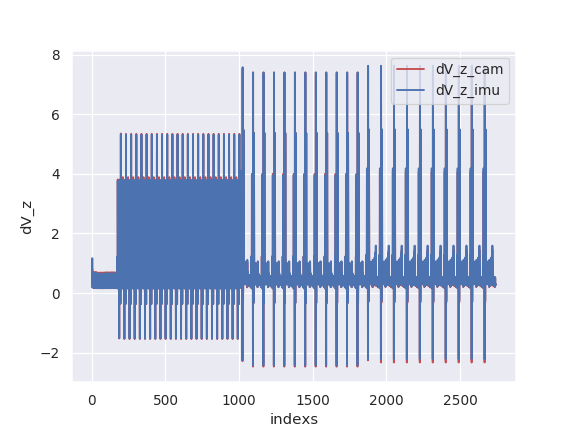

In [548]:
plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dV_x'], 'r', label='dV_x_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dV_x'], 'b', label='dV_x_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dV_x')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dV_y'], 'r', label='dV_y_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dV_y'], 'b', label='dV_y_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dV_y')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dV_z'], 'r', label='dV_z_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dV_z'], 'b', label='dV_z_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dV_z')
plt.show()

### scale

<IPython.core.display.Javascript object>


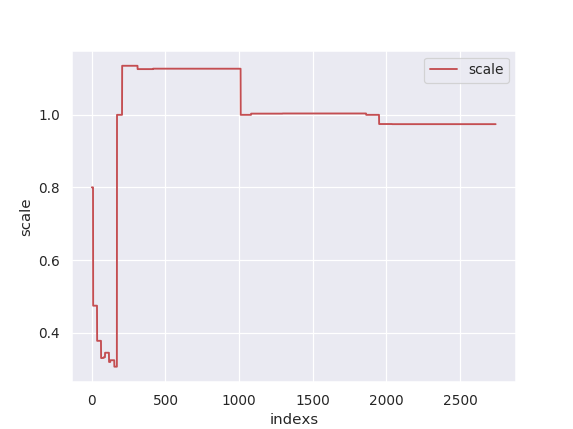

In [549]:
plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['scale'], 'r', label='scale')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('scale')
plt.show()

### dt

<IPython.core.display.Javascript object>


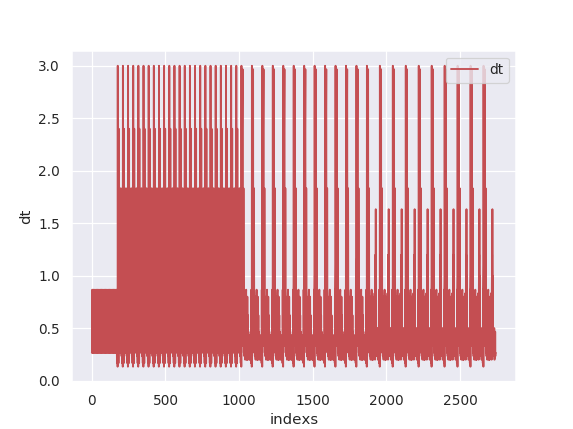

In [550]:
plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dt'], 'r', label='dt')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dt')
plt.show()

### dP

<IPython.core.display.Javascript object>


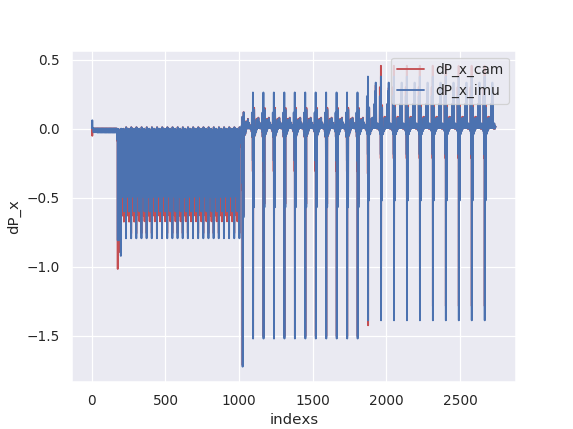

<IPython.core.display.Javascript object>


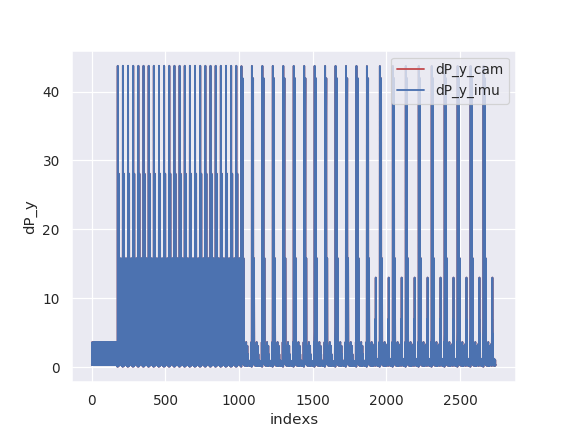

<IPython.core.display.Javascript object>


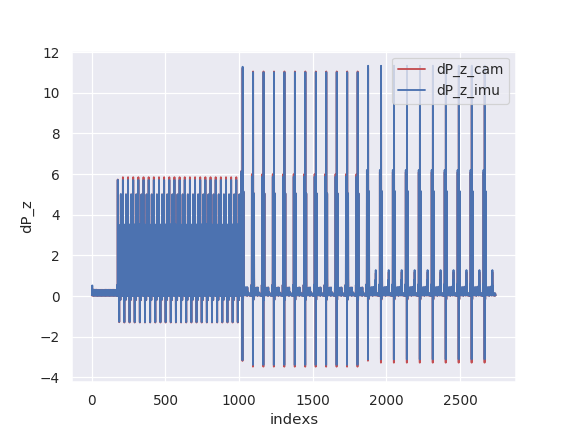

In [551]:
plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dP_x'], 'r', label='dP_x_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dP_x'], 'b', label='dP_x_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dP_x')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dP_y'], 'r', label='dP_y_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dP_y'], 'b', label='dP_y_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dP_y')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['dP_z'], 'r', label='dP_z_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['dP_z'], 'b', label='dP_z_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('dP_z')
plt.show()

### g

<IPython.core.display.Javascript object>


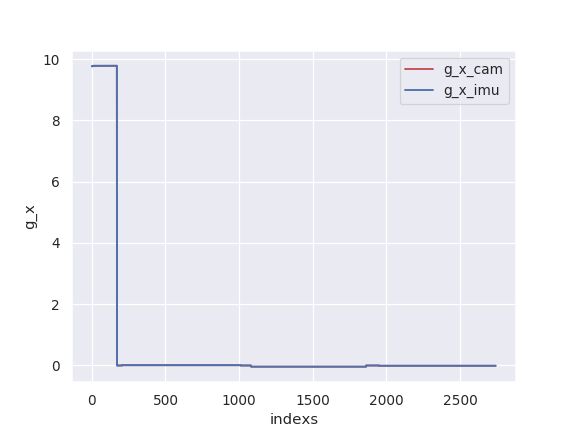

<IPython.core.display.Javascript object>


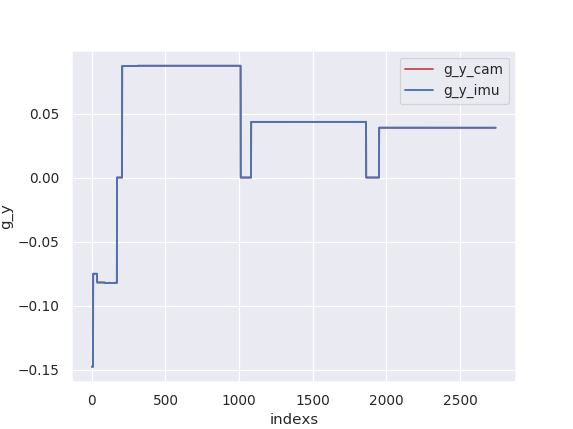

<IPython.core.display.Javascript object>


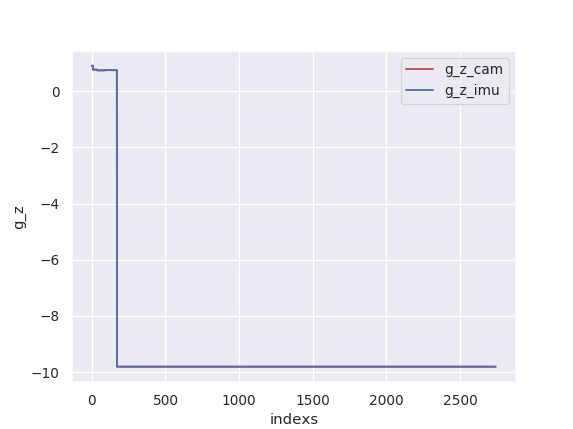

In [552]:
plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['g_x'], 'r', label='g_x_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['g_x'], 'b', label='g_x_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('g_x')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['g_y'], 'r', label='g_y_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['g_y'], 'b', label='g_y_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('g_y')
plt.show()

plt.figure()
plt.plot(range(len(imu_init_df_1)), imu_init_df_1['g_z'], 'r', label='g_z_cam')
plt.plot(range(len(imu_init_df_2)), imu_init_df_2['g_z'], 'b', label='g_z_imu')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('g_z')
plt.show()

## PIM Plotting

Plot preintegrated-imu-measurement estimates of current state over time. This comes in as a trajectory. The plots of error serve to help visualize the error in pim values over time.

Note that these pim values are built off the backend's estimation, not off of ground truth.

In [553]:
pim_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/output_logs/poses_pim.csv"
pim_df = pd.read_csv(pim_filename, sep=',', index_col=0)
rename_pim_df(pim_df)

#gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)
#output_poses_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/output_logs/poses_vio.csv"
output_poses_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/state_groundtruth_estimate0/data.csv"
#output_poses_filename = "/home/wxm/sda2/codes/Kimera-VIO/data/V1_01_easy/mav0/state_groundtruth_estimate0/data.csv"
gt_df = pd.read_csv(output_poses_filename, sep=',', index_col=0)
gt_df = gt_df[~gt_df.index.duplicated()]
# TODO: Add relative angle comparison plot between IMU and mono RANSAC

scale_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/output_logs/scale.csv"
scale_df = pd.read_csv(scale_filename, sep=',', index_col=0)
print(scale_df['scale'].unique())

[1.         0.30642704 1.12699087 1.0037405  0.97434259]


In [554]:
# Convert the gt relative-pose DataFrame to a trajectory object.
traj_ref = pandas_bridge.df_to_trajectory(gt_df)

# Use the mono ransac file as estimated trajectory.
# traj_est_unassociated = file_interface.read_swe_csv_trajectory(ransac_mono_filename)
traj_est_unaligned = pandas_bridge.df_to_trajectory(pim_df)

# Associate the data.
traj_est = copy.deepcopy(traj_est_unaligned)
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)
traj_est = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=False)

print("traj_ref: ", traj_ref)
print("traj_est: ", traj_est)

traj_ref:  2688 poses, 14.217m path length, 94.059s duration
traj_est:  2688 poses, 14.096m path length, 94.064s duration


### imu IntegrateNewMeasurement

#### read data

In [555]:
from scipy.spatial.transform import Rotation as R

timeshift = 0.0 #0.020768077  #t_imu = t_cam + timeshift 

input_imu_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/imu0/data.csv"
#input_imu_filename ="/home/wxm/sda2/codes/Kimera-VIO/data/V1_01_easy/mav0/imu0/data.csv"
imu_data_df = pd.read_csv(input_imu_filename, sep=',', index_col=0)
imu_data_df = imu_data_df[~imu_data_df.index.duplicated()]
imu_data_df.index = imu_data_df.index/1e9 - timeshift
#print(imu_data_df)#imu_data_df.index


tracking_pose_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/output_logs/poses_vio.csv"
#tracking_pose_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/state_groundtruth_estimate0/data.csv"
track_df = pd.read_csv(tracking_pose_filename, sep=',', index_col=0)
track_df = track_df[~track_df.index.duplicated()]
track_df.index = track_df.index/1e9
print(track_df)

keyframe_pose_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/output_logs/KeyFrameTrajectory.csv"
keyframe_df = pd.read_csv(keyframe_pose_filename, sep=',', index_col=0)
keyframe_df = keyframe_df[~keyframe_df.index.duplicated()]
keyframe_df.index = keyframe_df.index/1e9
print(keyframe_df)

                     x         y         z        qw        qx        qy  \
#timestamp                                                                 
1.287738e+06  0.000595  0.014260 -0.004833 -0.081950 -0.007777 -0.008551   
1.287738e+06  0.001203  0.015601 -0.005071 -0.083723 -0.007697 -0.008844   
1.287738e+06  0.001546  0.015976 -0.005584 -0.086461 -0.007570 -0.009254   
1.287738e+06  0.001656  0.015304 -0.005209 -0.089165 -0.007398 -0.008515   
1.287738e+06  0.000572  0.014944 -0.005286 -0.091937 -0.006490 -0.008806   
...                ...       ...       ...       ...       ...       ...   
1.287834e+06 -1.358319  0.031689  0.200091 -0.044812  0.751216  0.022339   
1.287835e+06 -1.358401  0.031261  0.200061 -0.044893  0.750268  0.024084   
1.287835e+06 -1.358135  0.031238  0.199922 -0.044196  0.749586  0.024407   
1.287835e+06 -1.357603  0.031623  0.199810 -0.044419  0.749438  0.024292   
1.287835e+06 -1.357551  0.031505  0.199455 -0.046163  0.748868  0.025159   

           

#### IMU integrate functions

In [556]:
from scipy.spatial.transform import Rotation as R 

def LogSO3(Rot):
    tr = Rot[0,0] + Rot[1,1] + Rot[2,2] 
    w = np.array([(Rot[2,1] - Rot[1, 2]) / 2, (Rot[0,2] - Rot[2, 0]) / 2, (Rot[1,0] - Rot[0, 1]) / 2])
    costheta = (tr - 1.0) * 0.5
    if (costheta > 1 or costheta < -1):
        return w
    theta = math.acos(costheta);
    s = math.sin(theta);
    if (math.fabs(s) < 1e-5):
        return w;
    else:
        return theta * w / s;


class IMU_POINT:
    def __init__(self,t,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z):
        self.t = t
        self.a = np.array([acc_x,acc_y,acc_z]).reshape(3,1)
        self.w = np.array([gyro_x,gyro_y,gyro_z]).reshape(3,1)

class IMU_Pregrated:
    def __init__(self, input_bias_gyro, input_bias_acc, input_noise):
        self.bias_gyro = input_bias_gyro
        self.bias_acc = input_bias_acc
        self.noise = input_noise # ng,na, ngw,naw

        self.accelation = np.array([0,0,0]).reshape(3,1)
        self.angVel = np.array([0,0,0]).reshape(3,1)
        self.dR =  np.identity(3)
        self.dV = np.array([0,0,0]).reshape(3,1)
        self.dP = np.array([0,0,0]).reshape(3,1)
        self.dt = 0
        self.avgA = np.array([0,0,0]).reshape(3,1)
        self.avgW = np.array([0,0,0]).reshape(3,1)
        self.JRg = np.zeros( (3,3) )
        self.JVg = np.zeros( (3,3) )
        self.JVa = np.zeros( (3,3) )
        self.JPa = np.zeros( (3,3) )
        self.JPg = np.zeros( (3,3) )
        self.C = np.zeros( (15,15) ) #15x15
        #input_noise = [ng,na, ngw,naw]
        self.Nga = np.array([[input_noise[0]*input_noise[0], 0,0,0,0,0],
                             [0,input_noise[0]*input_noise[0],0,0,0,0],
                             [0,0,input_noise[0]*input_noise[0],0,0,0],
                             [0,0,0,input_noise[1]*input_noise[1],0,0],
                             [0,0,0,0,input_noise[1]*input_noise[1],0],
                             [0,0,0,0,0,input_noise[1]*input_noise[1]]])
        
        self.NgaWalk = np.array([[input_noise[2]*input_noise[2], 0,0,0,0,0],
                                 [0,input_noise[2]*input_noise[2],0,0,0,0],
                                 [0,0,input_noise[2]*input_noise[2],0,0,0],
                                 [0,0,0,input_noise[3]*input_noise[3],0,0],
                                 [0,0,0,0,input_noise[3]*input_noise[3],0],
                                 [0,0,0,0,0,input_noise[3]*input_noise[3]]])
        
    def IntegratedRotation(self, angVel, bias_gyro, time):
        x = (angVel[0] - bias_gyro[0]) * time
        y = (angVel[1] - bias_gyro[1]) * time
        z = (angVel[2] - bias_gyro[2]) * time
        
        I =  np.identity(3)
        
        d2 = x * x + y * y + z* z
        d = math.sqrt(d2)
        
        W = np.array([[0, -z, y],
                     [z,0,-x],
                     [-y,x,0]])
        eps = 1e-4
        if d< eps:
            deltaR = I + W
            rightJ = np.identity(3)
        else:
            deltaR = I + W * math.sin(d)/d + np.dot(W,W) * (1-math.cos(d))/d2
            rightJ = I - W * (1 - math.cos(d))/d2 + np.dot(W,W) * (d- math.sin(d))/(d2*d)
        
        return deltaR, rightJ
    
    def NormalizeRotation(self, R):
        u,sigma,vt = la.svd(R)
        return np.dot(u,vt)
    
    def IntegrateNewMeasurement(self, acc, angVel, dt):
        #Position is updated firstly, as it depends on previously computed velocity and rotation.
        #Velocity is updated secondly, as it depends on previously computed rotation.
        #Rotation is the last to be updated.

        acc = acc - self.bias_acc
        angVel = angVel - self.bias_gyro

        self.avgA = (self.avgA*self.dt + np.dot(self.dR, acc)*dt)/(self.dt+ dt)
        self.avgW = (self.avgW*self.dt + angVel * dt)/(self.dt + dt)
        
        #Update delta position dP and velocity dV (rely on no-updated delta rotation)
        self.dP = self.dP + np.dot(self.dV, dt) + 0.5*np.dot(self.dR, acc)*dt*dt
        self.dV = self.dV + np.dot(self.dR, acc)*dt
        
        #Compute velocity and position parts of matrices A and B (rely on non-updated delta rotation)
        Wacc = np.array([[0, -acc[2], acc[1]], 
                         [acc[2], 0, -acc[0]], 
                         [-acc[1], acc[0], 0]])
        
        A =  np.identity(9)
        B = np.zeros((9,6))
        
        A[3:6, :3] = -np.dot(self.dR*dt, Wacc)
        A[6:9, :3] = -np.dot(0.5 * self.dR*dt*dt, Wacc)
        A[6:9, 3:6] = np.identity(3) * dt
        B[3:6, 3:6] = self.dR * dt
        B[6:9, 3:6] = 0.5 * self.dR * dt * dt
        
        #Update position and velocity jacobians wrt bias correction
        self.JPa = self.JPa + self.JVa * dt - 0.5 * self.dR * dt * dt
        self.JPg = self.JPg + self.JVg * dt - np.dot(0.5 * self.dR * dt * dt, np.dot(Wacc,self.JRg))
        self.JVa = self.JVa - self.dR * dt
        self.JVg = self.JVg - self.dR * dt * Wacc * self.JRg
        
        #Update delta rotation
        deltaR, rightJ = self.IntegratedRotation(angVel,np.array([0,0,0]).reshape(3,1),dt)
        self.dR = self.NormalizeRotation(np.dot(self.dR,deltaR).astype(np.float))
        
        A[0:3, 0:3] = deltaR.T
        B[0:3, 0:3] = rightJ * dt
        
        #Update covariance
        self.C[0:9,0:9] = np.dot(np.dot(A, self.C[0:9, 0:9]), A.T)+ np.dot(np.dot(B, self.Nga), B.T)
        self.C[9:15,9:15] = self.C[9:15,9:15] + self.NgaWalk
        
        #Update rotation jacobian wrt bias correction
        self.JRg = np.dot(deltaR.T,self.JRg) - rightJ * dt
        
        #Total integrated time
        self.dt = self.dt + dt

#### input params

In [562]:
input_bias_gyro=  np.array([3.0950101775696988e-05,0.006012689046254651,0.029800951457269294] ).reshape(3,1) 
#input_bias_acc = np.array([-0.11697233605889579,0.15606173897170653,0.088843086119782741]).reshape(3,1) 
input_bias_acc = np.array([0.042146327482942669,0.15517093076812707,0.033785128977316996]).reshape(3,1) 
input_noise = np.array([9.0e-05,0.0008745,0.0001079,0.000918493]).reshape(4,1) #noiseGyro, noiseAcc, GyroWalk,AccWalk

Rbc = np.array([[-0.0018398560689410432, -0.9999939382820646, 0.0029560664356526522],
               [-0.9999833675812337,0.0018559790881973355, 0.005460760251027382],
               [-0.0054662135469269214, -0.002945970256228909,-0.9999807206985086]])
tbc = np.array([ -0.01426059, -0.01169266,-0.00756007]).reshape(3,1)

Rcb = Rbc.transpose()
tcb = -np.dot(Rcb, tbc)

print(tcb)


gravity = np.array([ 0.0, 0.0,-9.8]).reshape(3,1)

[[-0.01176003]
 [-0.01426107]
 [-0.00745392]]


In [558]:
#V101 Dataset
input_bias_gyro=  np.array([-0.002461720313895994,0.021545980885023415,0.077201791898019442] ).reshape(3,1) 
input_bias_acc = np.array([0.0065882733584336122,0.031901816402845597,0.18726361939536321]).reshape(3,1) 
input_noise = np.array([9.0e-05,0.0008745,0.0001079,0.000918493]).reshape(4,1) #noiseGyro, noiseAcc, GyroWalk,AccWalk

            
Rbc = np.array([[0.0148655429818, -0.999880929698, 0.00414029679422], 
                [0.999557249008, 0.0149672133247, 0.025715529948],
                [-0.0257744366974, 0.00375618835797, 0.999660727178]])
tbc = np.array([ -0.0216401454975, -0.064676986768,0.00981073058949]).reshape(3,1)
Rcb = Rbc.transpose()
tcb = -np.dot(Rcb, tbc)

print(tcb)
gravity = np.array([ 0.0, 0.0,-9.8]).reshape(3,1)

[[ 0.06522291]
 [-0.02070639]
 [-0.0080546 ]]


#### compute relative pose

In [563]:
#choose time span:  tracking_frame or keyframe
used_idxs = keyframe_df.index
used_cam_pose_df = keyframe_df
print(len(used_idxs))
print(keyframe_df)

#used_idxs = track_df.index
#used_cam_pose_df = track_df

152
                     x         y         z        qw        qx        qy  \
#timestamp                                                                 
1.287734e+06 -0.743203 -9.368027  1.704037  0.641917 -0.071055 -0.760082   
1.287736e+06 -0.763320 -9.399795  1.709383  0.640236 -0.096853 -0.756866   
1.287736e+06 -0.760843 -9.342941  1.712736  0.647376 -0.036451 -0.760487   
1.287739e+06 -0.790089 -9.208688  1.711374  0.651053  0.105039 -0.746441   
1.287740e+06 -0.781969 -9.225993  1.710501  0.653219  0.085208 -0.749451   
...                ...       ...       ...       ...       ...       ...   
1.287811e+06 -3.232513 -8.635098  1.821476  0.554434 -0.393430 -0.645361   
1.287812e+06 -3.208843 -8.672342  1.826168  0.553222 -0.405745 -0.631243   
1.287812e+06 -3.187923 -8.708344  1.828170  0.547444 -0.419918 -0.625208   
1.287813e+06 -3.181729 -8.752551  1.826172  0.553547 -0.410082 -0.628994   
1.287813e+06 -3.183836 -8.777282  1.828182  0.552979 -0.409940 -0.628652   

       

In [564]:
#preintegrated imu in frame pose
first_im=0
for idx_imu in imu_data_df.index:
    if idx_imu < used_idxs[0]:
        first_im = first_im+1
        
print(first_im)

length_define = len(used_idxs)
#translation for plot
plot_translation_x = []
plot_translation_y = []
plot_translation_z = []
plot_translation_x_imu = []
plot_translation_y_imu = []
plot_translation_z_imu = []

#rotation for plot
plot_rotation_x = []
plot_rotation_y = []
plot_rotation_z = []
plot_rotation_x_imu = []
plot_rotation_y_imu = []
plot_rotation_z_imu = []

#velocity for plot 
plot_vx = []
plot_vy = []
plot_vz = []
plot_vx_imu = []
plot_vy_imu = []
plot_vz_imu = []



last_cam_idx = 0
for idx_cam in used_idxs:
    vec_imu = []
    mvImuFrom = IMU_Pregrated(input_bias_gyro, input_bias_acc, input_noise)
    while(imu_data_df.index[first_im] < idx_cam):
        imu_d = IMU_POINT(imu_data_df.index[first_im],
                          imu_data_df['a_RS_S_x [m s^-2]'].get(imu_data_df.index[first_im]),
                          imu_data_df['a_RS_S_y [m s^-2]'].get(imu_data_df.index[first_im]),
                          imu_data_df['a_RS_S_z [m s^-2]'].get(imu_data_df.index[first_im]),
                          imu_data_df['w_RS_S_x [rad s^-1]'].get(imu_data_df.index[first_im]),
                          imu_data_df['w_RS_S_y [rad s^-1]'].get(imu_data_df.index[first_im]),
                          imu_data_df['w_RS_S_z [rad s^-1]'].get(imu_data_df.index[first_im]))
        
        first_im  = first_im+1
        vec_imu.append(imu_d)
    print(len(vec_imu))
    #preintegrated imu
    n = len(vec_imu)
    if(n>0):
        #print(len(vec_imu))
        for i in range(n):
            if i>0 and i < (n-1):
                tstep = vec_imu[i+1].t - vec_imu[i].t
                acc = (vec_imu[i+1].a + vec_imu[i].a)*0.5
                angVel = (vec_imu[i+1].w + vec_imu[i].w)*0.5
                mvImuFrom.IntegrateNewMeasurement(acc, angVel, tstep)
                
        imu_dr = LogSO3(mvImuFrom.dR)
        print("imu_dr==")
        print(imu_dr)
        
        ######################################## relative_R #################################################
        cur_qw = used_cam_pose_df['qw'][used_cam_pose_df.index ==idx_cam].array[0]
        cur_qx = used_cam_pose_df['qx'][used_cam_pose_df.index ==idx_cam].array[0]
        cur_qy = used_cam_pose_df['qy'][used_cam_pose_df.index ==idx_cam].array[0]
        cur_qz = used_cam_pose_df['qz'][used_cam_pose_df.index ==idx_cam].array[0]

        last_qw = used_cam_pose_df['qw'][used_cam_pose_df.index ==last_cam_idx].array[0]
        last_qx = used_cam_pose_df['qx'][used_cam_pose_df.index ==last_cam_idx].array[0]
        last_qy = used_cam_pose_df['qy'][used_cam_pose_df.index ==last_cam_idx].array[0]
        last_qz = used_cam_pose_df['qz'][used_cam_pose_df.index ==last_cam_idx].array[0]
        
        cur_Rcw = R.from_quat([cur_qx, cur_qy, cur_qz, cur_qw]).as_matrix()  #Rcw
        cur_r = np.dot(cur_Rcw.transpose(), Rcb)    # (x, y, z, w)    Rwb = Rwc*Rcb
        last_Rcw = R.from_quat([last_qx, last_qy, last_qz, last_qw]).as_matrix() #Rcw
        last_r = np.dot(last_Rcw.transpose(), Rcb)  # (x, y, z, w)  Rwb = Rwc*Rcb
        relative_r = np.dot(last_r.transpose(),cur_r) #dR = Rwb1.transpose() * Rwb2
        cam_dr = LogSO3(relative_r)
        
        print("cam_dr==")
        print(cam_dr)
        
        if len(plot_rotation_x)<length_define:
            plot_rotation_x.append(cam_dr[0])
            plot_rotation_y.append(cam_dr[1])
            plot_rotation_z.append(cam_dr[2])
            
            plot_rotation_x_imu.append(imu_dr[0])
            plot_rotation_y_imu.append(imu_dr[1])
            plot_rotation_z_imu.append(imu_dr[2])
            
        ######################################### relative_velocity ################################################
        last_vx = used_cam_pose_df['vx'][used_cam_pose_df.index ==last_cam_idx].array[0]
        last_vy = used_cam_pose_df['vy'][used_cam_pose_df.index ==last_cam_idx].array[0]
        last_vz = used_cam_pose_df['vz'][used_cam_pose_df.index ==last_cam_idx].array[0]
        last_v = np.array([last_vx,last_vy,last_vz]).reshape(3,1) #imu frame velocity
        
        cur_vx = used_cam_pose_df['vx'][used_cam_pose_df.index ==idx_cam].array[0]
        cur_vy = used_cam_pose_df['vy'][used_cam_pose_df.index ==idx_cam].array[0]
        cur_vz = used_cam_pose_df['vz'][used_cam_pose_df.index ==idx_cam].array[0]
        cur_v = np.array([cur_vx,cur_vy,cur_vz]).reshape(3,1) #imu frame velocity
        
        dt = idx_cam-last_cam_idx
        print("imu_dV = ")
        imu_dV = mvImuFrom.dV
        print(imu_dV)
        cam_dV = np.dot(last_r.transpose(),(cur_v - last_v - gravity * dt))
        print("cam_dV = ")
        print(cam_dV)
        if len(plot_vx)<length_define:
            plot_vx.append(cam_dV[0])
            plot_vy.append(cam_dV[1])
            plot_vz.append(cam_dV[2])
            
            plot_vx_imu.append(imu_dV[0])
            plot_vy_imu.append(imu_dV[1])
            plot_vz_imu.append(imu_dV[2])
            
        
        ######################################### relative_t ################################################
        imu_dP = mvImuFrom.dP
        
        #relative pose between last frame and current frame
        cur_dP_x = used_cam_pose_df['x'][used_cam_pose_df.index ==idx_cam].array[0] 
        cur_dP_y = used_cam_pose_df['y'][used_cam_pose_df.index ==idx_cam].array[0]
        cur_dP_z = used_cam_pose_df['z'][used_cam_pose_df.index ==idx_cam].array[0]
        last_dP_x = used_cam_pose_df['x'][used_cam_pose_df.index ==last_cam_idx].array[0]
        last_dP_y = used_cam_pose_df['y'][used_cam_pose_df.index ==last_cam_idx].array[0]
        last_dP_z = used_cam_pose_df['z'][used_cam_pose_df.index ==last_cam_idx].array[0]
        
        cur_tcw = np.array([cur_dP_x,cur_dP_y,cur_dP_z]).reshape(3,1) #camera frame           tcw
        last_tcw = np.array([last_dP_x,last_dP_y,last_dP_z]).reshape(3,1) #last camera frame  tcw
        
        cur_Ow  = -np.dot(cur_Rcw.transpose(), cur_tcw)
        last_Ow = -np.dot(last_Rcw.transpose(), last_tcw)
        
        cur_dP  =  np.dot(cur_Rcw.transpose(), tcb) + cur_Ow #to imu frame
        last_dP =  np.dot(last_Rcw.transpose(),tcb) + last_Ow #to imu frame
        
        dt = idx_cam-last_cam_idx
        cam_dP = np.dot(last_r.transpose(), (cur_dP - last_dP - last_v * dt - gravity * dt * dt / 2))
        
        #print((cur_dP - last_dP - last_v * dt - g * dt * dt / 2))
        if len(plot_rotation_x)<length_define:
            plot_translation_x.append(cam_dP[0])
            plot_translation_y.append(cam_dP[1])
            plot_translation_z.append(cam_dP[2])
            plot_translation_x_imu.append(imu_dP[0])
            plot_translation_y_imu.append(imu_dP[1])
            plot_translation_z_imu.append(imu_dP[2])
        
        print("imu_dP = ")
        print(imu_dP)
        print("cam_dP = ")
        print(cam_dP)
        print("------------------------------------------------")
        
    last_cam_idx = idx_cam

826
0
582
imu_dr==
[ 0.00204664 -0.05775377 -0.02050472]
cam_dr==
[ 0.00019787 -0.05931105 -0.01815602]
imu_dV = 
[[3.45496723e-03]
 [1.37850470e+01]
 [2.33618415e+00]]
cam_dV = 
[[ 0.04296621]
 [13.82698901]
 [ 2.42107759]]
imu_dP = 
[[3.46952208e-03]
 [9.83456555e+00]
 [1.67306991e+00]]
cam_dP = 
[[-0.12406447]
 [10.04935387]
 [ 1.17361549]]
------------------------------------------------
216
imu_dr==
[0.00687051 0.15855948 0.02177895]
cam_dr==
[0.00675013 0.16049695 0.02319299]
imu_dV = 
[[0.02819916]
 [5.09161233]
 [0.84812785]]
cam_dV = 
[[0.05597509]
 [5.14832974]
 [0.89098129]]
imu_dP = 
[[0.00448669]
 [1.34209097]
 [0.22224091]]
cam_dP = 
[[0.53245609]
 [1.14563032]
 [1.69243816]]
------------------------------------------------
1206
imu_dr==
[0.02556418 0.37338273 0.04918481]
cam_dr==
[0.02534974 0.37321268 0.05558449]
imu_dV = 
[[ 0.18920447]
 [28.69742279]
 [ 4.55280509]]
cam_dV = 
[[ 0.37543311]
 [28.66718364]
 [ 4.75297955]]
imu_dP = 
[[ 0.21905288]
 [42.48877701]
 [ 6.80

imu_dr==
[ 0.05276362  0.01264469 -0.01546132]
cam_dr==
[ 0.05224249  0.01248701 -0.01447419]
imu_dV = 
[[-0.18045048]
 [ 4.68180985]
 [ 1.28228839]]
cam_dV = 
[[-0.16684296]
 [ 4.72230433]
 [ 1.32528515]]
imu_dP = 
[[-0.04413545]
 [ 1.15616955]
 [ 0.31219352]]
cam_dP = 
[[-0.0851615 ]
 [ 1.21730278]
 [ 0.44436506]]
------------------------------------------------
203
imu_dr==
[0.0290492  0.06345583 0.05759822]
cam_dr==
[0.02883733 0.06423519 0.05888574]
imu_dV = 
[[-0.2403307 ]
 [ 4.71492437]
 [ 1.06798404]]
cam_dV = 
[[-0.22781922]
 [ 4.75589086]
 [ 1.1044859 ]]
imu_dP = 
[[-0.05812467]
 [ 1.1632166 ]
 [ 0.2548385 ]]
cam_dP = 
[[0.01722826]
 [0.61029452]
 [0.91566066]]
------------------------------------------------
122
imu_dr==
[0.01931459 0.07918644 0.05745891]
cam_dr==
[0.01930479 0.08009112 0.05849837]
imu_dV = 
[[-0.0867537 ]
 [ 2.81480769]
 [ 0.63107785]]
cam_dV = 
[[-0.07749753]
 [ 2.85129102]
 [ 0.65277629]]
imu_dP = 
[[-0.00934728]
 [ 0.41355325]
 [ 0.0961431 ]]
cam_dP = 
[

149
imu_dr==
[0.00636543 0.01074048 0.00528963]
cam_dr==
[0.0057088  0.01074198 0.00544939]
imu_dV = 
[[0.05156202]
 [3.52100024]
 [0.4731459 ]]
cam_dV = 
[[0.05657789]
 [3.56041091]
 [0.49430959]]
imu_dP = 
[[0.00241317]
 [0.63661614]
 [0.08251974]]
cam_dP = 
[[0.09074285]
 [0.57277697]
 [0.22336539]]
------------------------------------------------
135
imu_dr==
[0.00767105 0.03239807 0.00563162]
cam_dr==
[0.00722673 0.03279209 0.00550208]
imu_dV = 
[[0.0987314 ]
 [3.18237482]
 [0.41702067]]
cam_dV = 
[[0.10366927]
 [3.23396244]
 [0.43672399]]
imu_dP = 
[[0.01352541]
 [0.52153331]
 [0.06702027]]
cam_dP = 
[[0.14940103]
 [0.45048878]
 [0.39591031]]
------------------------------------------------
203
imu_dr==
[0.02228386 0.04894333 0.00618644]
cam_dr==
[0.02168059 0.04917402 0.00585969]
imu_dV = 
[[0.14260913]
 [4.82387122]
 [0.65662611]]
cam_dV = 
[[0.14554014]
 [4.86592462]
 [0.67682832]]
imu_dP = 
[[0.03280375]
 [1.19565913]
 [0.16641952]]
cam_dP = 
[[0.23933809]
 [1.07140548]
 [0.6

imu_dr==
[-0.00801706  0.02230859 -0.00381562]
cam_dr==
[-0.00887121  0.02244649 -0.00367336]
imu_dV = 
[[0.17749475]
 [4.48772217]
 [0.44406403]]
cam_dV = 
[[0.16205882]
 [4.54736163]
 [0.42842517]]
imu_dP = 
[[0.04218539]
 [1.03522471]
 [0.10589429]]
cam_dP = 
[[0.11278421]
 [1.0501456 ]
 [0.32108596]]
------------------------------------------------
447
imu_dr==
[0.01526033 0.14113599 0.02662133]
cam_dr==
[0.01481982 0.14118611 0.02742214]
imu_dV = 
[[ 0.31427064]
 [10.67616895]
 [ 1.19302712]]
cam_dV = 
[[ 0.2753867 ]
 [10.70946257]
 [ 1.14219342]]
imu_dP = 
[[0.18422651]
 [5.85187474]
 [0.63942303]]
cam_dP = 
[[0.57340641]
 [5.5736242 ]
 [1.73836989]]
------------------------------------------------
217
imu_dr==
[-0.04023792  0.04718401  0.02947059]
cam_dr==
[-0.04104153  0.0475314   0.03066102]
imu_dV = 
[[0.09837333]
 [5.1641768 ]
 [0.48431743]]
cam_dV = 
[[0.08193239]
 [5.19898629]
 [0.46402823]]
imu_dP = 
[[0.02571895]
 [1.36757746]
 [0.11974187]]
cam_dP = 
[[0.16373011]
 [1.2

imu_dr==
[0.01912917 0.03399486 0.00165277]
cam_dr==
[0.01876257 0.0337926  0.00130201]
imu_dV = 
[[0.0678468 ]
 [2.58517504]
 [0.26120594]]
cam_dV = 
[[0.05718444]
 [2.61573855]
 [0.25032815]]
imu_dP = 
[[0.01096471]
 [0.3430976 ]
 [0.03315656]]
cam_dP = 
[[0.0644674 ]
 [0.26032506]
 [0.26373386]]
------------------------------------------------
81
imu_dr==
[0.00110359 0.01818083 0.00793747]
cam_dr==
[0.00085285 0.01850971 0.00798859]
imu_dV = 
[[0.02905436]
 [1.8932912 ]
 [0.1658206 ]]
cam_dV = 
[[0.02040085]
 [1.94614642]
 [0.1598484 ]]
imu_dP = 
[[0.00294264]
 [0.1846968 ]
 [0.01551061]]
cam_dP = 
[[0.04043559]
 [0.10160662]
 [0.16967448]]
------------------------------------------------
149
imu_dr==
[-0.00674638  0.05593905  0.00542639]
cam_dr==
[-0.00742519  0.05599747  0.00511026]
imu_dV = 
[[0.05541735]
 [3.52845601]
 [0.32497188]]
cam_dV = 
[[0.04178749]
 [3.5737512 ]
 [0.30824935]]
imu_dP = 
[[0.01216496]
 [0.6367854 ]
 [0.05540205]]
cam_dP = 
[[0.10758421]
 [0.5621168 ]
 [0.

imu_dr==
[ 0.02371268  0.00725045 -0.00511886]
cam_dr==
[ 0.02251889  0.00770487 -0.00474821]
imu_dV = 
[[0.15615097]
 [3.8781614 ]
 [0.46135826]]
cam_dV = 
[[0.145182  ]
 [3.91245029]
 [0.43961568]]
imu_dP = 
[[0.02542711]
 [0.77132033]
 [0.08786147]]
cam_dP = 
[[-0.02568085]
 [ 0.74010264]
 [ 0.14247528]]
------------------------------------------------
162
imu_dr==
[ 0.00294679  0.00035473 -0.00918272]
cam_dr==
[ 0.0017061   0.00015249 -0.00965759]
imu_dV = 
[[0.09113774]
 [3.84665517]
 [0.4122664 ]]
cam_dV = 
[[0.07671136]
 [3.90586695]
 [0.39018735]]
imu_dP = 
[[0.01837158]
 [0.75661754]
 [0.08357102]]
cam_dP = 
[[-0.05503026]
 [ 0.81292113]
 [ 0.14106756]]
------------------------------------------------
204
imu_dr==
[-0.0175353   0.00434713 -0.01145364]
cam_dr==
[-0.01841332  0.00471358 -0.01243704]
imu_dV = 
[[0.15064699]
 [4.84457359]
 [0.54191579]]
cam_dV = 
[[0.12953853]
 [4.87031869]
 [0.50536521]]
imu_dP = 
[[0.03892266]
 [1.20175758]
 [0.13002725]]
cam_dP = 
[[-0.03555194

imu_dr==
[0.01091622 0.08605184 0.01165706]
cam_dr==
[0.01008034 0.08768419 0.01154926]
imu_dV = 
[[0.1640122 ]
 [4.15010064]
 [0.72129725]]
cam_dV = 
[[0.15041422]
 [4.19323705]
 [0.70068734]]
imu_dP = 
[[0.04395028]
 [0.89081555]
 [0.15345888]]
cam_dP = 
[[0.14414106]
 [0.75319337]
 [0.92629437]]
------------------------------------------------
135
imu_dr==
[0.00798133 0.02691702 0.00960868]
cam_dr==
[0.00729247 0.02807003 0.00964323]
imu_dV = 
[[0.07074576]
 [3.16206936]
 [0.53287701]]
cam_dV = 
[[0.06134016]
 [3.21489931]
 [0.52119649]]
imu_dP = 
[[0.01339982]
 [0.51762787]
 [0.08788894]]
cam_dP = 
[[0.00638643]
 [0.4049118 ]
 [0.34224666]]
------------------------------------------------
163
imu_dr==
[0.00830241 0.04508808 0.0130642 ]
cam_dr==
[0.00721924 0.04597482 0.01297669]
imu_dV = 
[[0.08545009]
 [3.82237384]
 [0.59491476]]
cam_dV = 
[[0.0719769 ]
 [3.85398257]
 [0.57286658]]
imu_dP = 
[[0.02175948]
 [0.75798726]
 [0.12312633]]
cam_dP = 
[[0.06337603]
 [0.60852286]
 [0.51091

#### plot relative R

<IPython.core.display.Javascript object>


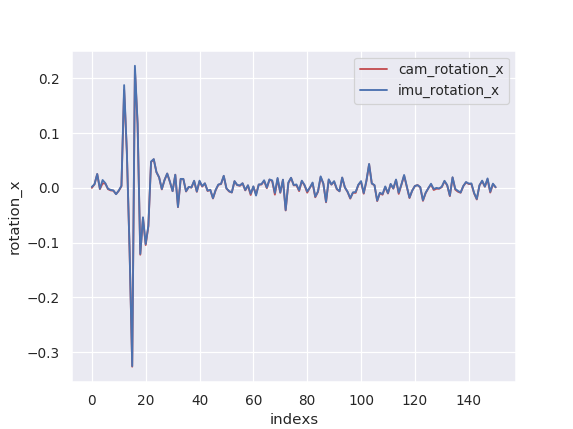

<IPython.core.display.Javascript object>


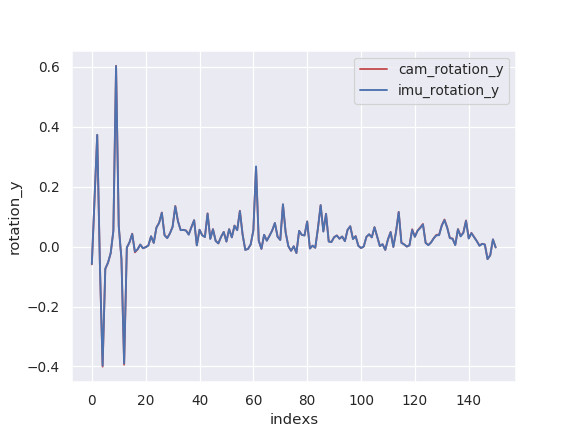

<IPython.core.display.Javascript object>


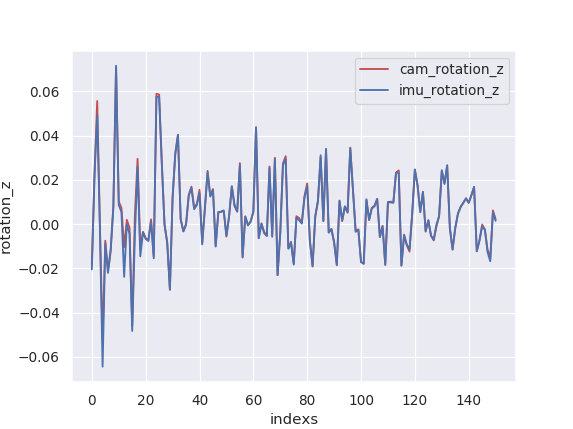

In [565]:
#plot 
plt.figure()
plt.plot(range(len(plot_rotation_x)), plot_rotation_x, 'r', label='cam_rotation_x')
plt.plot(range(len(plot_rotation_x_imu)), plot_rotation_x_imu, 'b', label='imu_rotation_x')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('rotation_x')
plt.show()

#plot 
plt.figure()
plt.plot(range(len(plot_rotation_y)), plot_rotation_y, 'r', label='cam_rotation_y')
plt.plot(range(len(plot_rotation_y_imu)), plot_rotation_y_imu, 'b', label='imu_rotation_y')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('rotation_y')
plt.show()

#plot 
plt.figure()
plt.plot(range(len(plot_rotation_z)), plot_rotation_z, 'r', label='cam_rotation_z')
plt.plot(range(len(plot_rotation_z_imu)), plot_rotation_z_imu, 'b', label='imu_rotation_z')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('rotation_z')
plt.show()


#### plot relative velocity

<IPython.core.display.Javascript object>


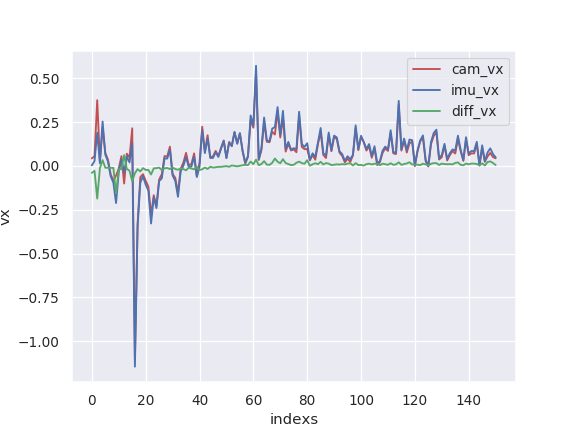

<IPython.core.display.Javascript object>


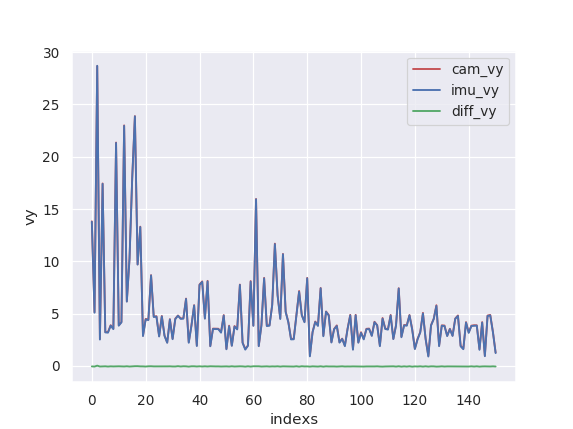

<IPython.core.display.Javascript object>


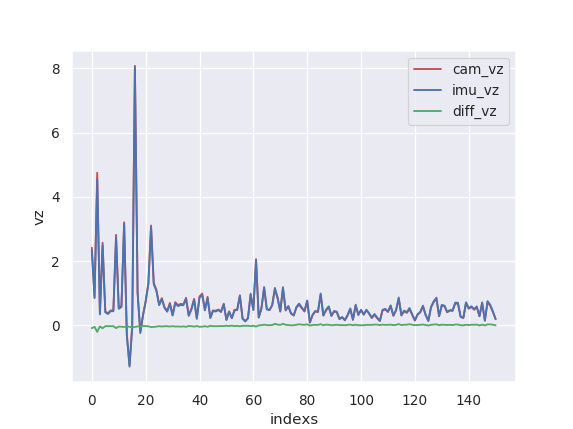

<IPython.core.display.Javascript object>


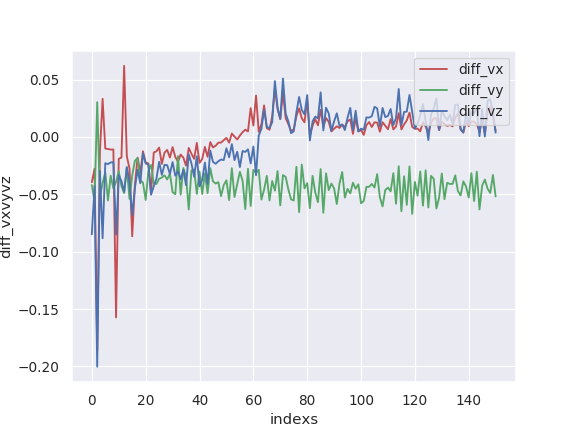

In [566]:
#plot 
plt.figure()
plt.plot(range(len(plot_vx)), plot_vx, 'r', label='cam_vx')
plt.plot(range(len(plot_vx_imu)), plot_vx_imu, 'b', label='imu_vx')
plt.plot(range(len(plot_vx_imu)), (np.array(plot_vx_imu)-np.array(plot_vx)), 'g', label='diff_vx')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('vx')
plt.show()

#plot 
plt.figure()
plt.plot(range(len(plot_vy)), plot_vy, 'r', label='cam_vy')
plt.plot(range(len(plot_vy_imu)), plot_vy_imu, 'b', label='imu_vy')
plt.plot(range(len(plot_vy_imu)), (np.array(plot_vy_imu)-np.array(plot_vy)), 'g', label='diff_vy')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('vy')
plt.show()

#plot 
plt.figure()
plt.plot(range(len(plot_vz)), plot_vz, 'r', label='cam_vz')
plt.plot(range(len(plot_vz_imu)), plot_vz_imu, 'b', label='imu_vz')
plt.plot(range(len(plot_vz_imu)), (np.array(plot_vz_imu)-np.array(plot_vz)), 'g', label='diff_vz')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('vz')
plt.show()

#plot diff xyz
plt.figure()
plt.plot(range(len(plot_vx_imu)), (np.array(plot_vx_imu)-np.array(plot_vx)), 'r', label='diff_vx')
plt.plot(range(len(plot_vy_imu)), (np.array(plot_vy_imu)-np.array(plot_vy)), 'g', label='diff_vy')
plt.plot(range(len(plot_vz_imu)), (np.array(plot_vz_imu)-np.array(plot_vz)), 'b', label='diff_vz')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('diff_vxvyvz')
plt.show()

#### plot relative t

<IPython.core.display.Javascript object>


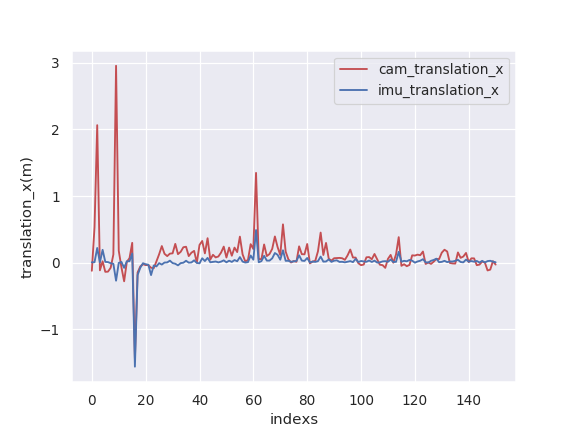

<IPython.core.display.Javascript object>


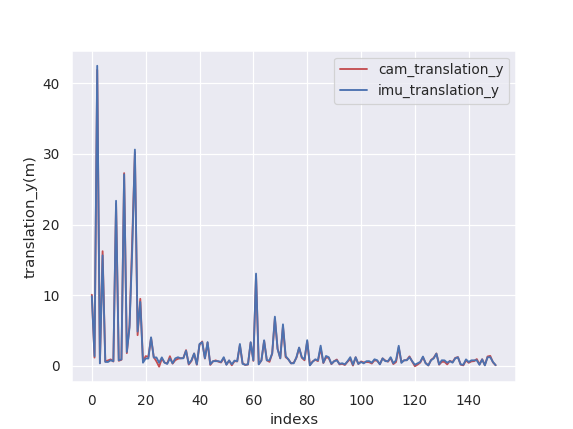

<IPython.core.display.Javascript object>


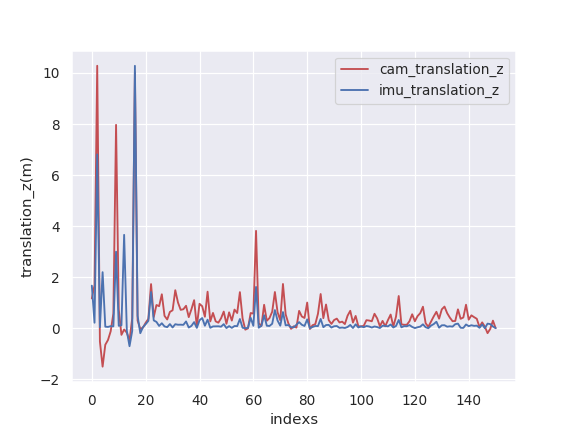

<IPython.core.display.Javascript object>


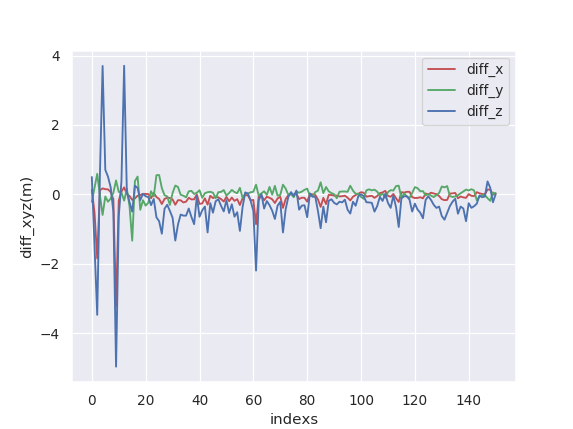

In [567]:
#plot 
plt.figure()
plt.plot(range(len(plot_translation_x)), plot_translation_x, 'r', label='cam_translation_x')
plt.plot(range(len(plot_translation_x_imu)), plot_translation_x_imu, 'b', label='imu_translation_x')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('translation_x(m)')
plt.show()

plt.figure()
plt.plot(range(len(plot_translation_y)), plot_translation_y, 'r', label='cam_translation_y')
plt.plot(range(len(plot_translation_y_imu)), plot_translation_y_imu, 'b', label='imu_translation_y')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('translation_y(m)')
plt.show()


#plot 
plt.figure()
plt.plot(range(len(plot_translation_z)), plot_translation_z, 'r', label='cam_translation_z')
plt.plot(range(len(plot_translation_z_imu)), plot_translation_z_imu, 'b', label='imu_translation_z')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('translation_z(m)')
plt.show()


#plot diff xyz
plt.figure()
plt.plot(range(len(plot_translation_x)), (np.array(plot_translation_x_imu)-np.array(plot_translation_x)), 'r', label='diff_x')
plt.plot(range(len(plot_translation_y)), (np.array(plot_translation_y_imu)-np.array(plot_translation_y)), 'g', label='diff_y')
plt.plot(range(len(plot_translation_z)), (np.array(plot_translation_z_imu)-np.array(plot_translation_z)), 'b', label='diff_z')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('indexs')
ax.set_ylabel('diff_xyz(m)')
plt.show()


### plot imu data

<IPython.core.display.Javascript object>


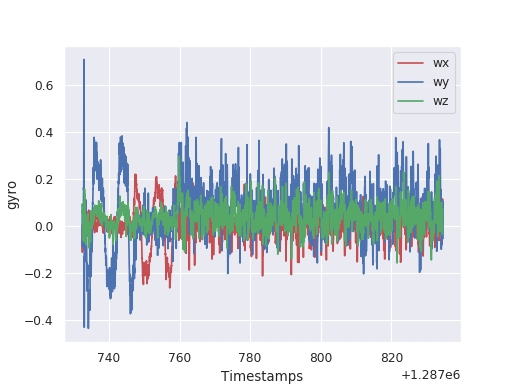

<IPython.core.display.Javascript object>


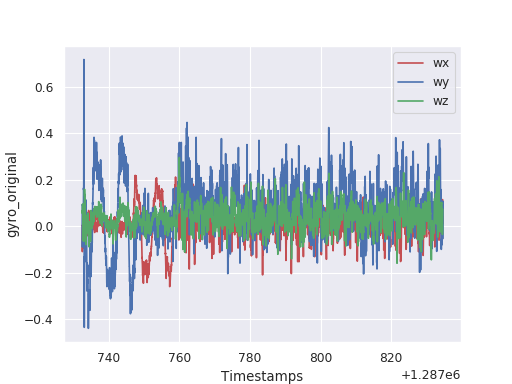

In [35]:
timeshift = 0.020  #t_imu = t_cam + timeshift
input_imu_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/imu0/data.csv"
imu_data_df = pd.read_csv(input_imu_filename, sep=',', index_col=0)
imu_data_df = imu_data_df[~imu_data_df.index.duplicated()]
imu_data_df.index = imu_data_df.index/1e9 - timeshift

#gyro rectify by scale-misalignment
plt.figure()
plt.plot(imu_data_df.index, imu_data_df['w_RS_S_x [rad s^-1]'], 'r', label='wx')
plt.plot(imu_data_df.index, imu_data_df['w_RS_S_y [rad s^-1]'], 'b', label='wy')
plt.plot(imu_data_df.index, imu_data_df['w_RS_S_z [rad s^-1]'], 'g', label='wz')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('Timestamps')
ax.set_ylabel('gyro')
plt.show()

#gyro original
input_imu_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/imu0/data_original.csv"
imu_data_df = pd.read_csv(input_imu_filename, sep=',', index_col=0)
imu_data_df = imu_data_df[~imu_data_df.index.duplicated()]
imu_data_df.index = imu_data_df.index/1e9 + timeshift

plt.figure()
plt.plot(imu_data_df.index, imu_data_df['w_RS_S_x [rad s^-1]'], 'r', label='wx')
plt.plot(imu_data_df.index, imu_data_df['w_RS_S_y [rad s^-1]'], 'b', label='wy')
plt.plot(imu_data_df.index, imu_data_df['w_RS_S_z [rad s^-1]'], 'g', label='wz')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('Timestamps')
ax.set_ylabel('gyro_original')
plt.show()

<IPython.core.display.Javascript object>


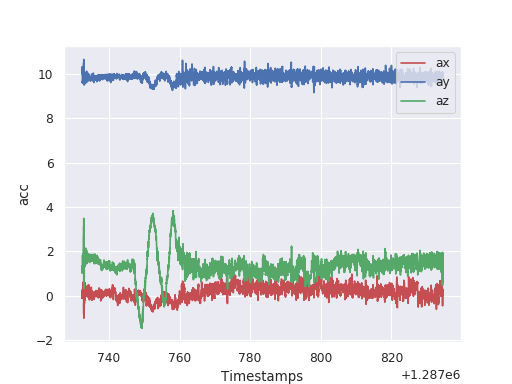

<IPython.core.display.Javascript object>


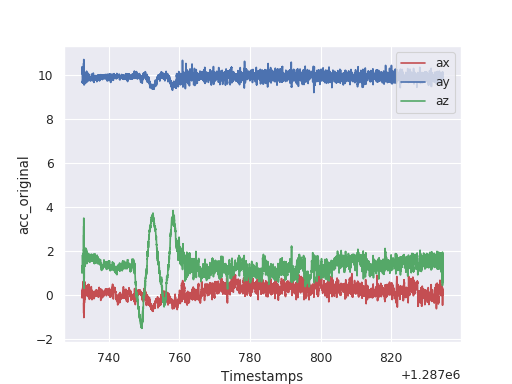

In [37]:
timeshift = 0.020  #t_imu = t_cam + timeshift
input_imu_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/imu0/data.csv"
imu_data_df = pd.read_csv(input_imu_filename, sep=',', index_col=0)
imu_data_df = imu_data_df[~imu_data_df.index.duplicated()]
imu_data_df.index = imu_data_df.index/1e9 - timeshift

#acc rectify by scale-misalignment
plt.figure()
plt.plot(imu_data_df.index, imu_data_df['a_RS_S_x [m s^-2]'], 'r', label='ax')
plt.plot(imu_data_df.index, imu_data_df['a_RS_S_y [m s^-2]'], 'b', label='ay')
plt.plot(imu_data_df.index, imu_data_df['a_RS_S_z [m s^-2]'], 'g', label='az')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('Timestamps')
ax.set_ylabel('acc')
plt.show()


#acc original
input_imu_filename = "/home/wxm/Documents/code/ORB_SLAM3/data/06_05_15_43_Circle/mav0/imu0/data_original.csv"
imu_data_df = pd.read_csv(input_imu_filename, sep=',', index_col=0)
imu_data_df = imu_data_df[~imu_data_df.index.duplicated()]
imu_data_df.index = imu_data_df.index/1e9 + timeshift

plt.figure()
plt.plot(imu_data_df.index, imu_data_df['a_RS_S_x [m s^-2]'], 'r', label='ax')
plt.plot(imu_data_df.index, imu_data_df['a_RS_S_y [m s^-2]'], 'b', label='ay')
plt.plot(imu_data_df.index, imu_data_df['a_RS_S_z [m s^-2]'], 'g', label='az')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('Timestamps')
ax.set_ylabel('acc_original')
plt.show()


### Relative Angles
This plot compares the relative angles between GT and PIM outputs.

<IPython.core.display.Javascript object>


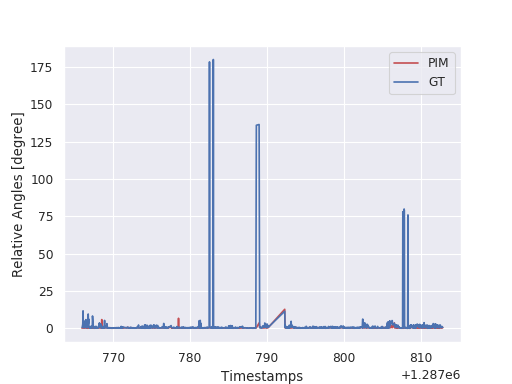

In [38]:
# Convert to relative traj
traj_ref_rel = convert_abs_traj_to_rel_traj(traj_ref, up_to_scale=False)
traj_est_rel = convert_abs_traj_to_rel_traj(traj_est, up_to_scale=False)

# Plot the PIM angles
PIM_angles = []
PIM_angles_timestamps = []
for i in range(len(traj_est_rel._poses_se3)):
    PIM_angles_timestamps.append(traj_est_rel.timestamps[i])
    # quaternion to axisangle
    rotm = traj_est_rel._poses_se3[i][0:3,0:3]
    r = R.from_dcm(rotm)
    
    rot_vec = r.as_rotvec()
    PIM_angles.append(np.linalg.norm(rot_vec)*180/3.14)


# Plot the GT angles
gt_angles = []
gt_angles_timestamps = []
for i in range(len(traj_ref_rel._poses_se3)):
    gt_angles_timestamps.append(traj_ref_rel.timestamps[i])
    # rotation matrix to axisangle
    rotm = traj_ref_rel._poses_se3[i][0:3,0:3]
    r = R.from_dcm(rotm)
    
    rot_vec = r.as_rotvec()
    gt_angles.append(np.linalg.norm(rot_vec)*180/3.14)

    
plt.figure()
plt.plot(PIM_angles_timestamps, PIM_angles, 'r', label='PIM')
plt.plot(gt_angles_timestamps, gt_angles, 'b',  label='GT')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_xlabel('Timestamps')
ax.set_ylabel('Relative Angles [degree]')

plt.show()

In [39]:
# Get RPE for entire relative trajectory.
rpe_rot = get_rpe_rot((traj_ref, traj_est))
rpe_tran = get_rpe_trans((traj_ref, traj_est))

<IPython.core.display.Javascript object>


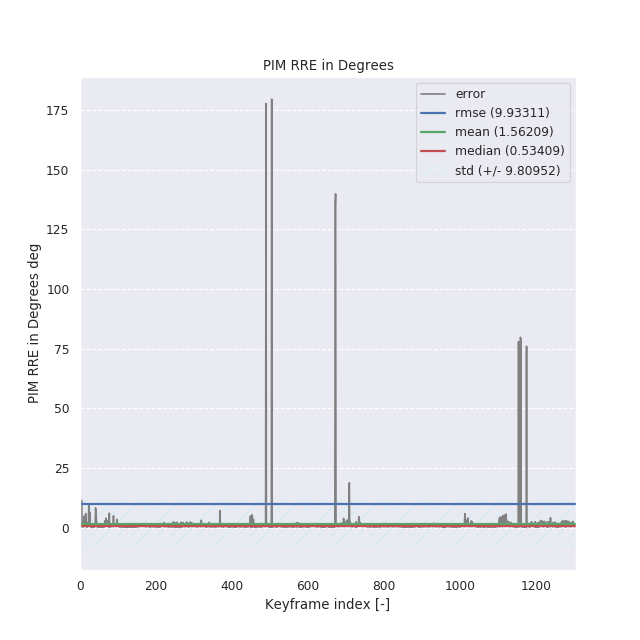

<IPython.core.display.Javascript object>


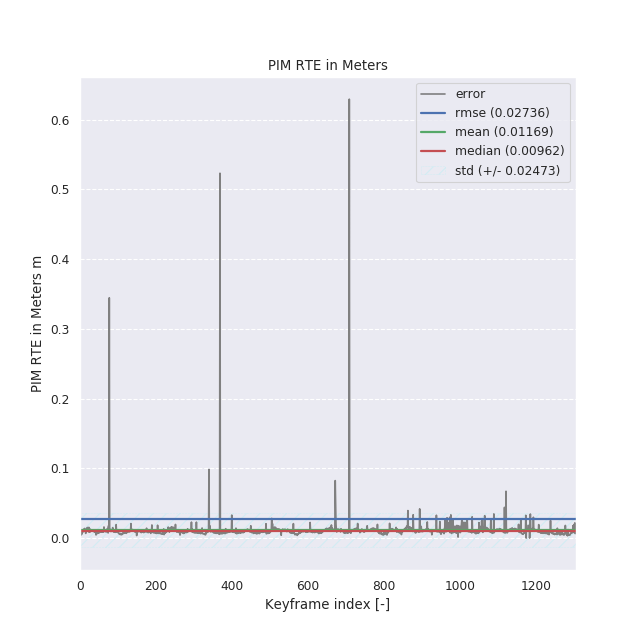

In [40]:
# Plot RPE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

plot_metric(rpe_rot, "PIM RRE in Degrees")
plot_metric(rpe_tran, "PIM RTE in Meters")
plt.show()

<IPython.core.display.Javascript object>


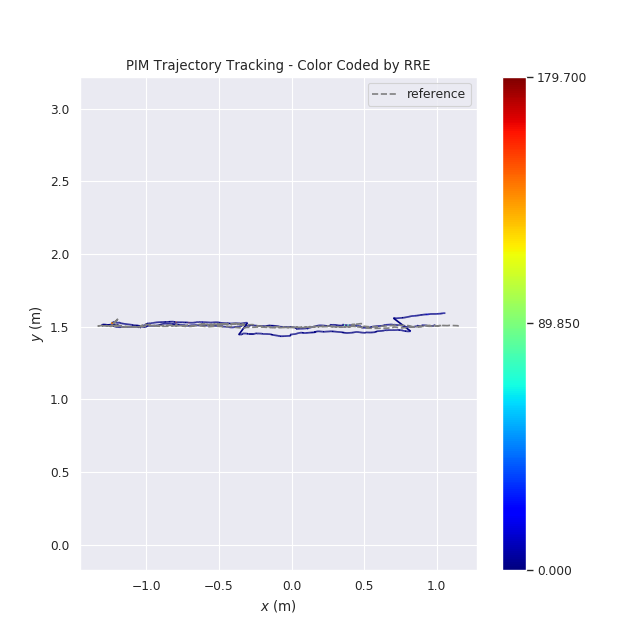

In [41]:
fig = plot_traj_colormap_rpe(rpe_rot, traj_ref, traj_est,
                             plot_title="PIM Trajectory Tracking - Color Coded by RRE")
plt.show()

<IPython.core.display.Javascript object>


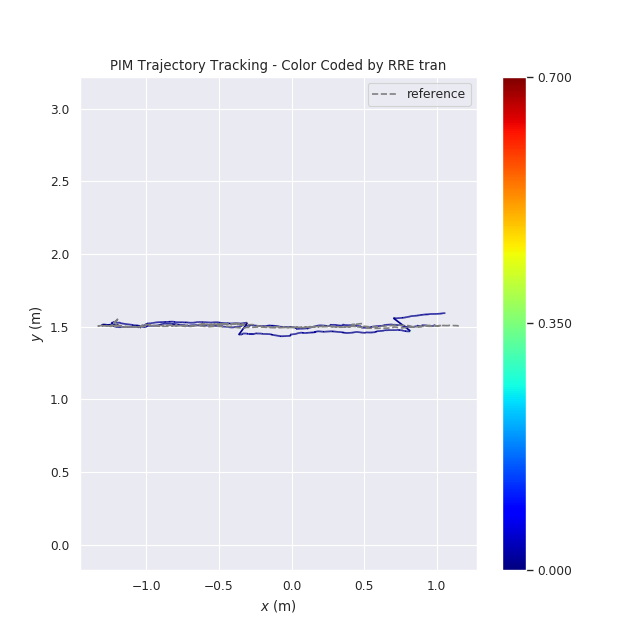

In [42]:
fig = plot_traj_colormap_rpe(rpe_tran, traj_ref, traj_est,
                             plot_title="PIM Trajectory Tracking - Color Coded by RRE tran")
plt.show()

# Smart Factors
Plot smart factors vs. time

<IPython.core.display.Javascript object>


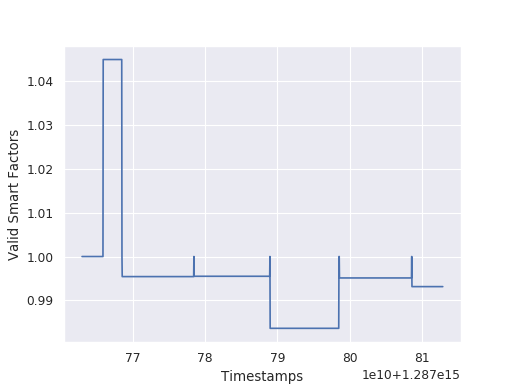

                    scale
#timestamp               
1287762928528809  1.00000
1287762961849434  1.00000
1287762995170059  1.00000
1287763028490736  1.00000
1287763061811361  1.00000
...                   ...
1287812689547922  0.99315
1287812722868547  0.99315
1287812789509797  0.99315
1287812822830422  0.99315
1287812889471672  0.99315

[1491 rows x 1 columns]


In [43]:
#output_sf_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_smartFactors.csv")
output_sf_filename ="/home/wxm/Documents/code/ORB_SLAM3/data/output_logs/scale.csv"
output_sf_df = pd.read_csv(output_sf_filename, sep=',', index_col=0)
fig = plt.figure()
print(output_sf_df)

#plt.plot(output_sf_df.timestamp_kf/1e9, output_sf_df.numValid)
plt.plot(output_sf_df["scale"])
plt.ylabel('Valid Smart Factors')
plt.xlabel('Timestamps')
plt.show()

# Biases
Plot biases of gyro and accelerometer

<IPython.core.display.Javascript object>


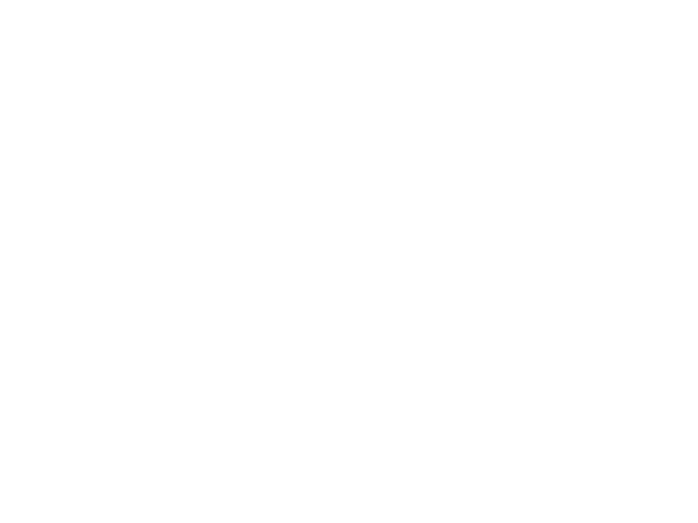

AttributeError: 'DataFrame' object has no attribute 'bgx'

In [190]:
fig = plt.figure()
plt.plot(output_poses_df.index, output_poses_df.bgx)
plt.plot(output_poses_df.index, output_poses_df.bgy)
plt.plot(output_poses_df.index, output_poses_df.bgz)
plt.ylabel('Gyro Biases')
plt.xlabel('Timestamps')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(output_poses_df.index, output_poses_df.bax)
plt.plot(output_poses_df.index, output_poses_df.bay)
plt.plot(output_poses_df.index, output_poses_df.baz)
plt.ylabel('Acceleration Biases')
plt.xlabel('Timestamps')
plt.legend()
plt.show()